In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
import os 
from torch.utils.data import DataLoader, TensorDataset
import torch

In [2]:
%matplotlib notebook

In [3]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
num_epochs = 10000

In [5]:
# Load the conditions into a Pandas DataFrame
excel_path = './conditions.xlsx'
conditions_df = pd.read_excel(excel_path)

# Display the DataFrame to verify the contents
conditions_df


,Sample Name,Power (W),Speed (mm/s)
0,a,71,21
1,b,85,30
2,c,55,21
3,d,66,30
4,e,85,50
5,f,55,30
6,g,70,50


In [6]:
## Set up the main parameters are all in mm
spot_radius = 0.071
eta = 0.44
O_PD = 0.02

T_amb = 27.0

rho = 8000 *1e-9 #kg/(mm)^3
Cp = 500.0 #J/(kgK)
kappa = 45 * 1e-3 #W/(mmK)

T_max = 5500 #K
T_min = T_amb

T_melt = 1417

mu = 7 #mPa s
dgamma_dt = 2e-4 #N/(m * K)

In [7]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# Function to get CSV files in a folder
def get_csv_files_in_folder(folder_path):
    csv_file_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            full_file_path = os.path.join(folder_path, filename)
            csv_file_paths.append(full_file_path)
    return csv_file_paths

# Function to extract sample name from CSV file name
def extract_sample_name_from_csv(filename):
    # The sample name is the part of the filename before the last underscore or the file extension
    return os.path.splitext(filename)[0].split('_')[-1]


In [9]:
# Folder_path is where the CSV files are stored
folder_path = './Data/'  
csv_file_paths = get_csv_files_in_folder(folder_path)

csv_file_paths

['./Data/data_sample_g.csv',
 './Data/data_sample_d.csv',
 './Data/data_sample_c.csv',
 './Data/data_sample_a.csv',
 './Data/data_sample_e.csv',
 './Data/data_sample_f.csv',
 './Data/data_sample_b.csv']

In [10]:
# Dictionary to store summary statistics for each dataset
summary_statistics = {}

# Loop through each file path and generate summary statistics
for file_path in csv_file_paths:
    df = pd.read_csv(file_path)
    filename = os.path.basename(file_path)
    sample_name = extract_sample_name_from_csv(filename)
    
    if sample_name in conditions_df['Sample Name'].values:
        summary_statistics[sample_name] = df.describe()
    else:
        print(f"Warning: Sample name {sample_name} from {filename} not found in Excel data.")

# Display the summary statistics for verification
for sample, stats in summary_statistics.items():
    print(f"Summary statistics for sample {sample}:\n{stats}\n")


Summary statistics for sample g:
            x(um)       y(um)    Vx(mm/s)    Vy(mm/s)  Circular variance  \
count  405.000000  405.000000  405.000000  405.000000         405.000000   
mean    72.242500  -45.972500   -4.029064    4.396171           0.107504   
std    102.433491   56.819877   56.907633   63.788638           0.238721   
min    -98.512500 -137.917500 -391.747434 -433.455000           0.000000   
25%    -19.702500  -98.512500    0.000000    0.000000           0.000000   
50%     72.242500  -45.972500    0.000000    0.000000           0.000000   
75%    164.187500    6.567500    0.000000    0.000000           0.000000   
max    242.997500   45.972500  383.217565  394.050000           0.973342   

       particle numbers  
count        405.000000  
mean           0.723457  
std            1.748427  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max           15.000000  

Summary statistics for sample d:
            x(

In [11]:
# Dictionary to store the actual data for each dataset
data_frames = {}

# Loop through each file path, read the data, and store both the summary statistics and the data
for file_path in csv_file_paths:
    df = pd.read_csv(file_path)
    filename = os.path.basename(file_path)
    sample_name = extract_sample_name_from_csv(filename)
    
    if sample_name in conditions_df['Sample Name'].values:
        summary_statistics[sample_name] = df.describe()
        data_frames[sample_name] = df  # Storing the actual data
    else:
        print(f"Warning: Sample name {sample_name} from {filename} not found in Excel data.")


<IPython.core.display.Javascript object>


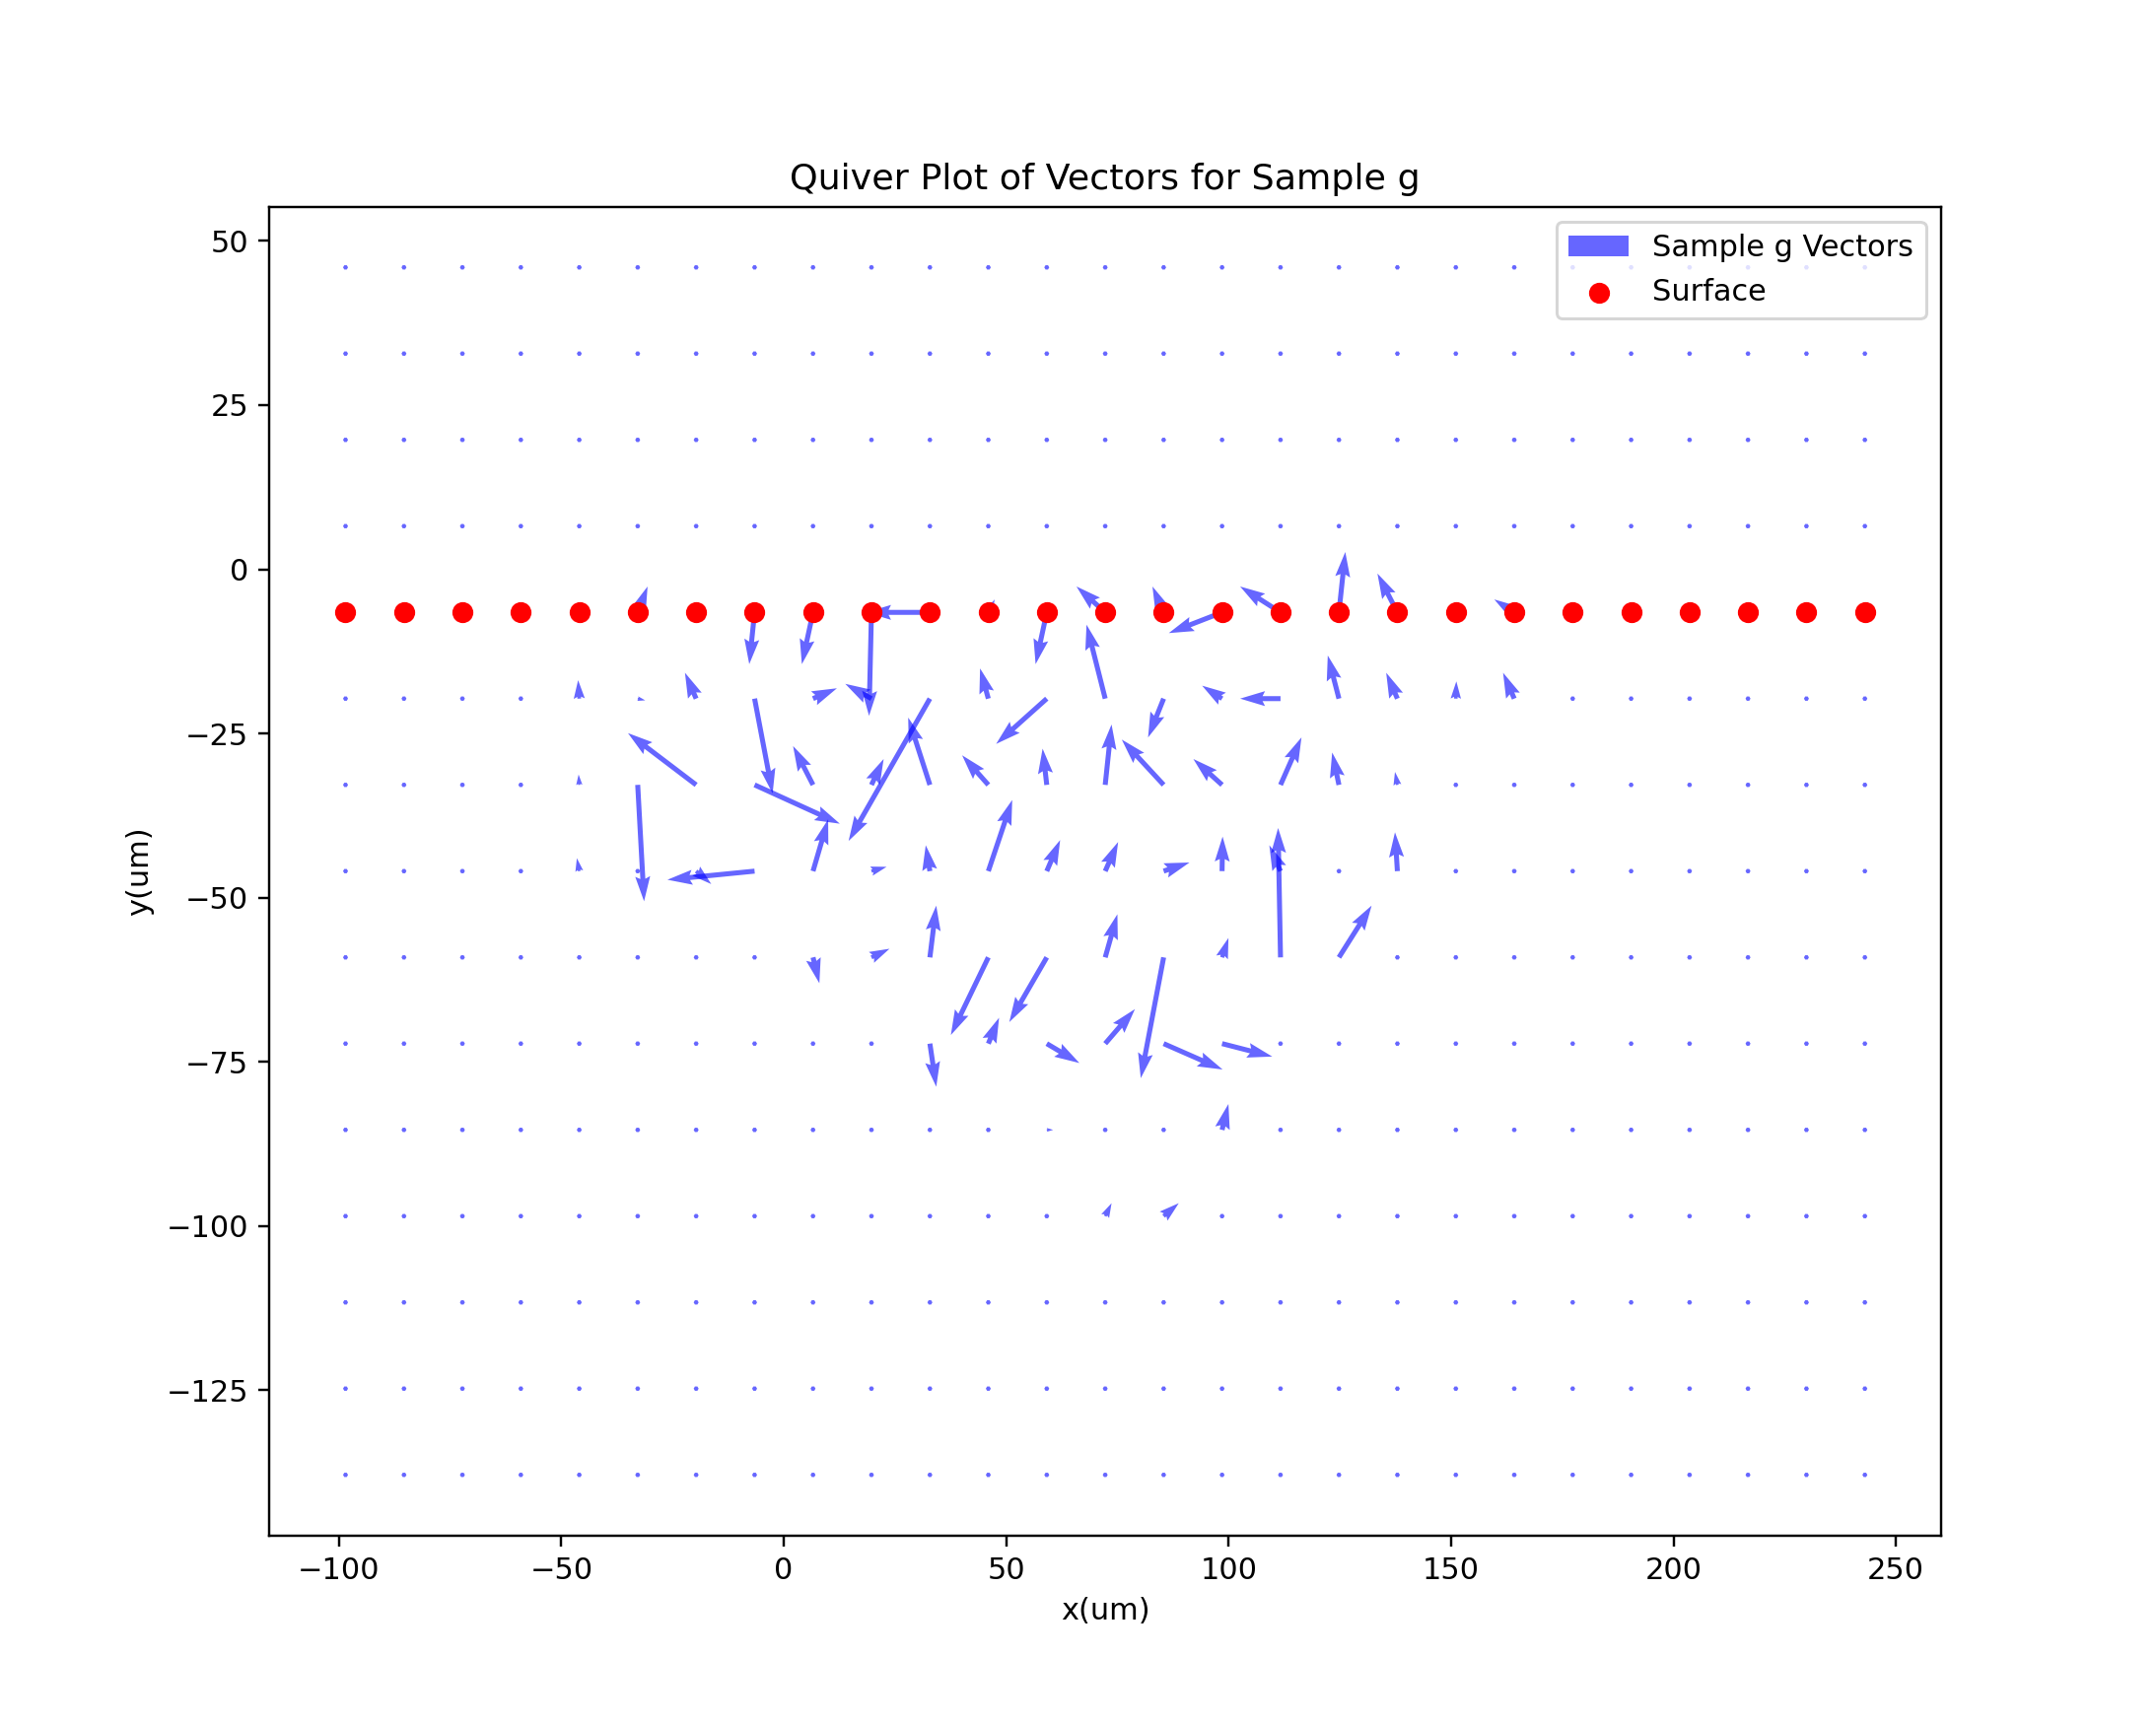

In [12]:
# Define the variable names
variables = list(summary_statistics['a'].columns)

# Loop through each sample and create quiver plots for x and y
for sample, df in data_frames.items():
    plt.figure(figsize=(10, 8))
    
    # Find the minimum absolute distance to y=0
    min_distance_to_zero = np.min(np.abs(df[variables[1]]))

    # Identify all rows where y is closest to 0
    closest_to_zero_rows = df[np.abs(df[variables[1]]) == min_distance_to_zero]

    # Filter to get only the negative y values
    closest_to_zero_rows_negative = closest_to_zero_rows[closest_to_zero_rows[variables[1]] < 0]

    # Quiver plot to show vectors; setting scale to make arrows smaller
    plt.quiver(df[variables[0]], df[variables[1]], df[variables[2]], df[variables[3]], 
               angles='xy', scale_units='xy', scale=20, color='blue', alpha=0.6, label=f'Sample {sample} Vectors')

    # Highlight the negative points closest to y=0 with red dots
    plt.scatter(closest_to_zero_rows_negative[variables[0]], closest_to_zero_rows_negative[variables[1]], 
                color='red', zorder=5, label='Surface')
    
    # Labels and title
    plt.xlabel(variables[0])
    plt.ylabel(variables[1])
    plt.title(f'Quiver Plot of Vectors for Sample {sample}')
    plt.legend()
    
    plt.show()
    break


In [13]:
# Resolution for the grid
resolution = 13.135  # in um

# Calculate the number of points on either side of z=0
num_points_side = int(180 / resolution)

# Generate z coordinates ranging from -50 um to +50 um with the given resolution
# Make sure to include 0 in the middle
z_coordinates = torch.cat([
    torch.arange(-num_points_side * resolution, -0.1, resolution),  # Left of zero
    torch.tensor([0.0]),                                          # Zero
    torch.arange(resolution, num_points_side * resolution + 0.1, resolution)  # Right of zero
])

# Dictionary to store the 3D coordinates as PyTorch tensors for each sample
sample_coordinates = {}

# Loop through each sample and create 3D coordinates
for sample, df in data_frames.items():
    # Extract x and y coordinates from the DataFrame and convert them to PyTorch tensors
    x_coordinates = torch.tensor(df[variables[0]].values, dtype=torch.float32)
    y_coordinates = torch.tensor(df[variables[1]].values, dtype=torch.float32)
    
    # Create empty tensor to store the 3D coordinates (x, y, z) for each point
    total_points = len(x_coordinates) * len(z_coordinates)
    coords_3D = torch.zeros(total_points, 3)
    
    # Fill the 3D coordinates tensor
    index = 0
    for z in z_coordinates:
        for i in range(len(x_coordinates)):
            coords_3D[index, 0] = x_coordinates[i]
            coords_3D[index, 1] = y_coordinates[i]
            coords_3D[index, 2] = z
            index += 1
    
    # Store the 3D coordinates tensor for the sample
    sample_coordinates[sample] = coords_3D

# After generating 3D coordinates for all samples
# Loop to filter out coordinates with positive y-values
for sample in sample_coordinates.keys():
    coords_3D = sample_coordinates[sample]
    coords_filtered = coords_3D[coords_3D[:, 1] <= 0]
    sample_coordinates[sample] = coords_filtered

In [14]:
# Initialize variables to store the global maximum and minimum values for x, y, and z
global_x_max = float('-inf')
global_y_max = float('-inf')
global_z_max = float('-inf')
global_x_min = float('inf')
global_y_min = float('inf')
global_z_min = float('inf')

# Loop through each sample to find the global maximum and minimum for x, y, and z
for sample, coords in sample_coordinates.items():
    global_x_max = max(global_x_max, coords[:, 0].max())
    global_y_max = max(global_y_max, coords[:, 1].max())
    global_z_max = max(global_z_max, coords[:, 2].max())
    
    global_x_min = min(global_x_min, coords[:, 0].min())
    global_y_min = min(global_y_min, coords[:, 1].min())
    global_z_min = min(global_z_min, coords[:, 2].min())

# Calculate the global minimum and maximum values for speed and power
global_speed_min = conditions_df['Speed (mm/s)'].min()
global_speed_max = conditions_df['Speed (mm/s)'].max()
global_power_min = conditions_df['Power (W)'].min()
global_power_max = conditions_df['Power (W)'].max()

# Display the calculated global values
print(f"Global Minimum Speed: {global_speed_min} mm/s")
print(f"Global Maximum Speed: {global_speed_max} mm/s")
print(f"Global Minimum Power: {global_power_min} W")
print(f"Global Maximum Power: {global_power_max} W")
print(f"Global Maximum X: {global_x_max} um")
print(f"Global Maximum Y: {global_y_max} um")
print(f"Global Maximum Z: {global_z_max} um")
print(f"Global Minimum X: {global_x_min} um")
print(f"Global Minimum Y: {global_y_min} um")
print(f"Global Minimum Z: {global_z_min} um")


Global Minimum Speed: 21 mm/s
Global Maximum Speed: 50 mm/s
Global Minimum Power: 55 W
Global Maximum Power: 85 W
Global Maximum X: 295.5375061035156 um
Global Maximum Y: -6.567500114440918 um
Global Maximum Z: 170.7550048828125 um
Global Minimum X: -98.51249694824219 um
Global Minimum Y: -242.99749755859375 um
Global Minimum Z: -170.7550048828125 um


In [15]:
# Dictionary to store the boundary and interior coordinates as PyTorch tensors for each sample
sample_boundary_coordinates = {}
sample_interior_coordinates = {}

# Loop through each sample and separate boundary and interior points
for sample, coords_3D in sample_coordinates.items():
    x_min = coords_3D[:, 0].min()
    x_max = coords_3D[:, 0].max()
    y_min = coords_3D[:, 1].min()
    
    # Define conditions for boundary points
    cond_x_min = (coords_3D[:, 0] == x_min)
    cond_x_max = (coords_3D[:, 0] == x_max)
    cond_y_min = (coords_3D[:, 1] == y_min)
    
    # Extract boundary points
    boundary_points = coords_3D[cond_y_min] # cond_x_max cond_x_min
    
    # Extract interior points
    interior_points = coords_3D[~(cond_y_min)] # cond_x_max cond_x_min
    
    # Store them in dictionaries
    sample_boundary_coordinates[sample] = boundary_points
    sample_interior_coordinates[sample] = interior_points

# `sample_boundary_coordinates` contains the boundary points and
# `sample_interior_coordinates` contains the interior points for each sample.


<IPython.core.display.Javascript object>


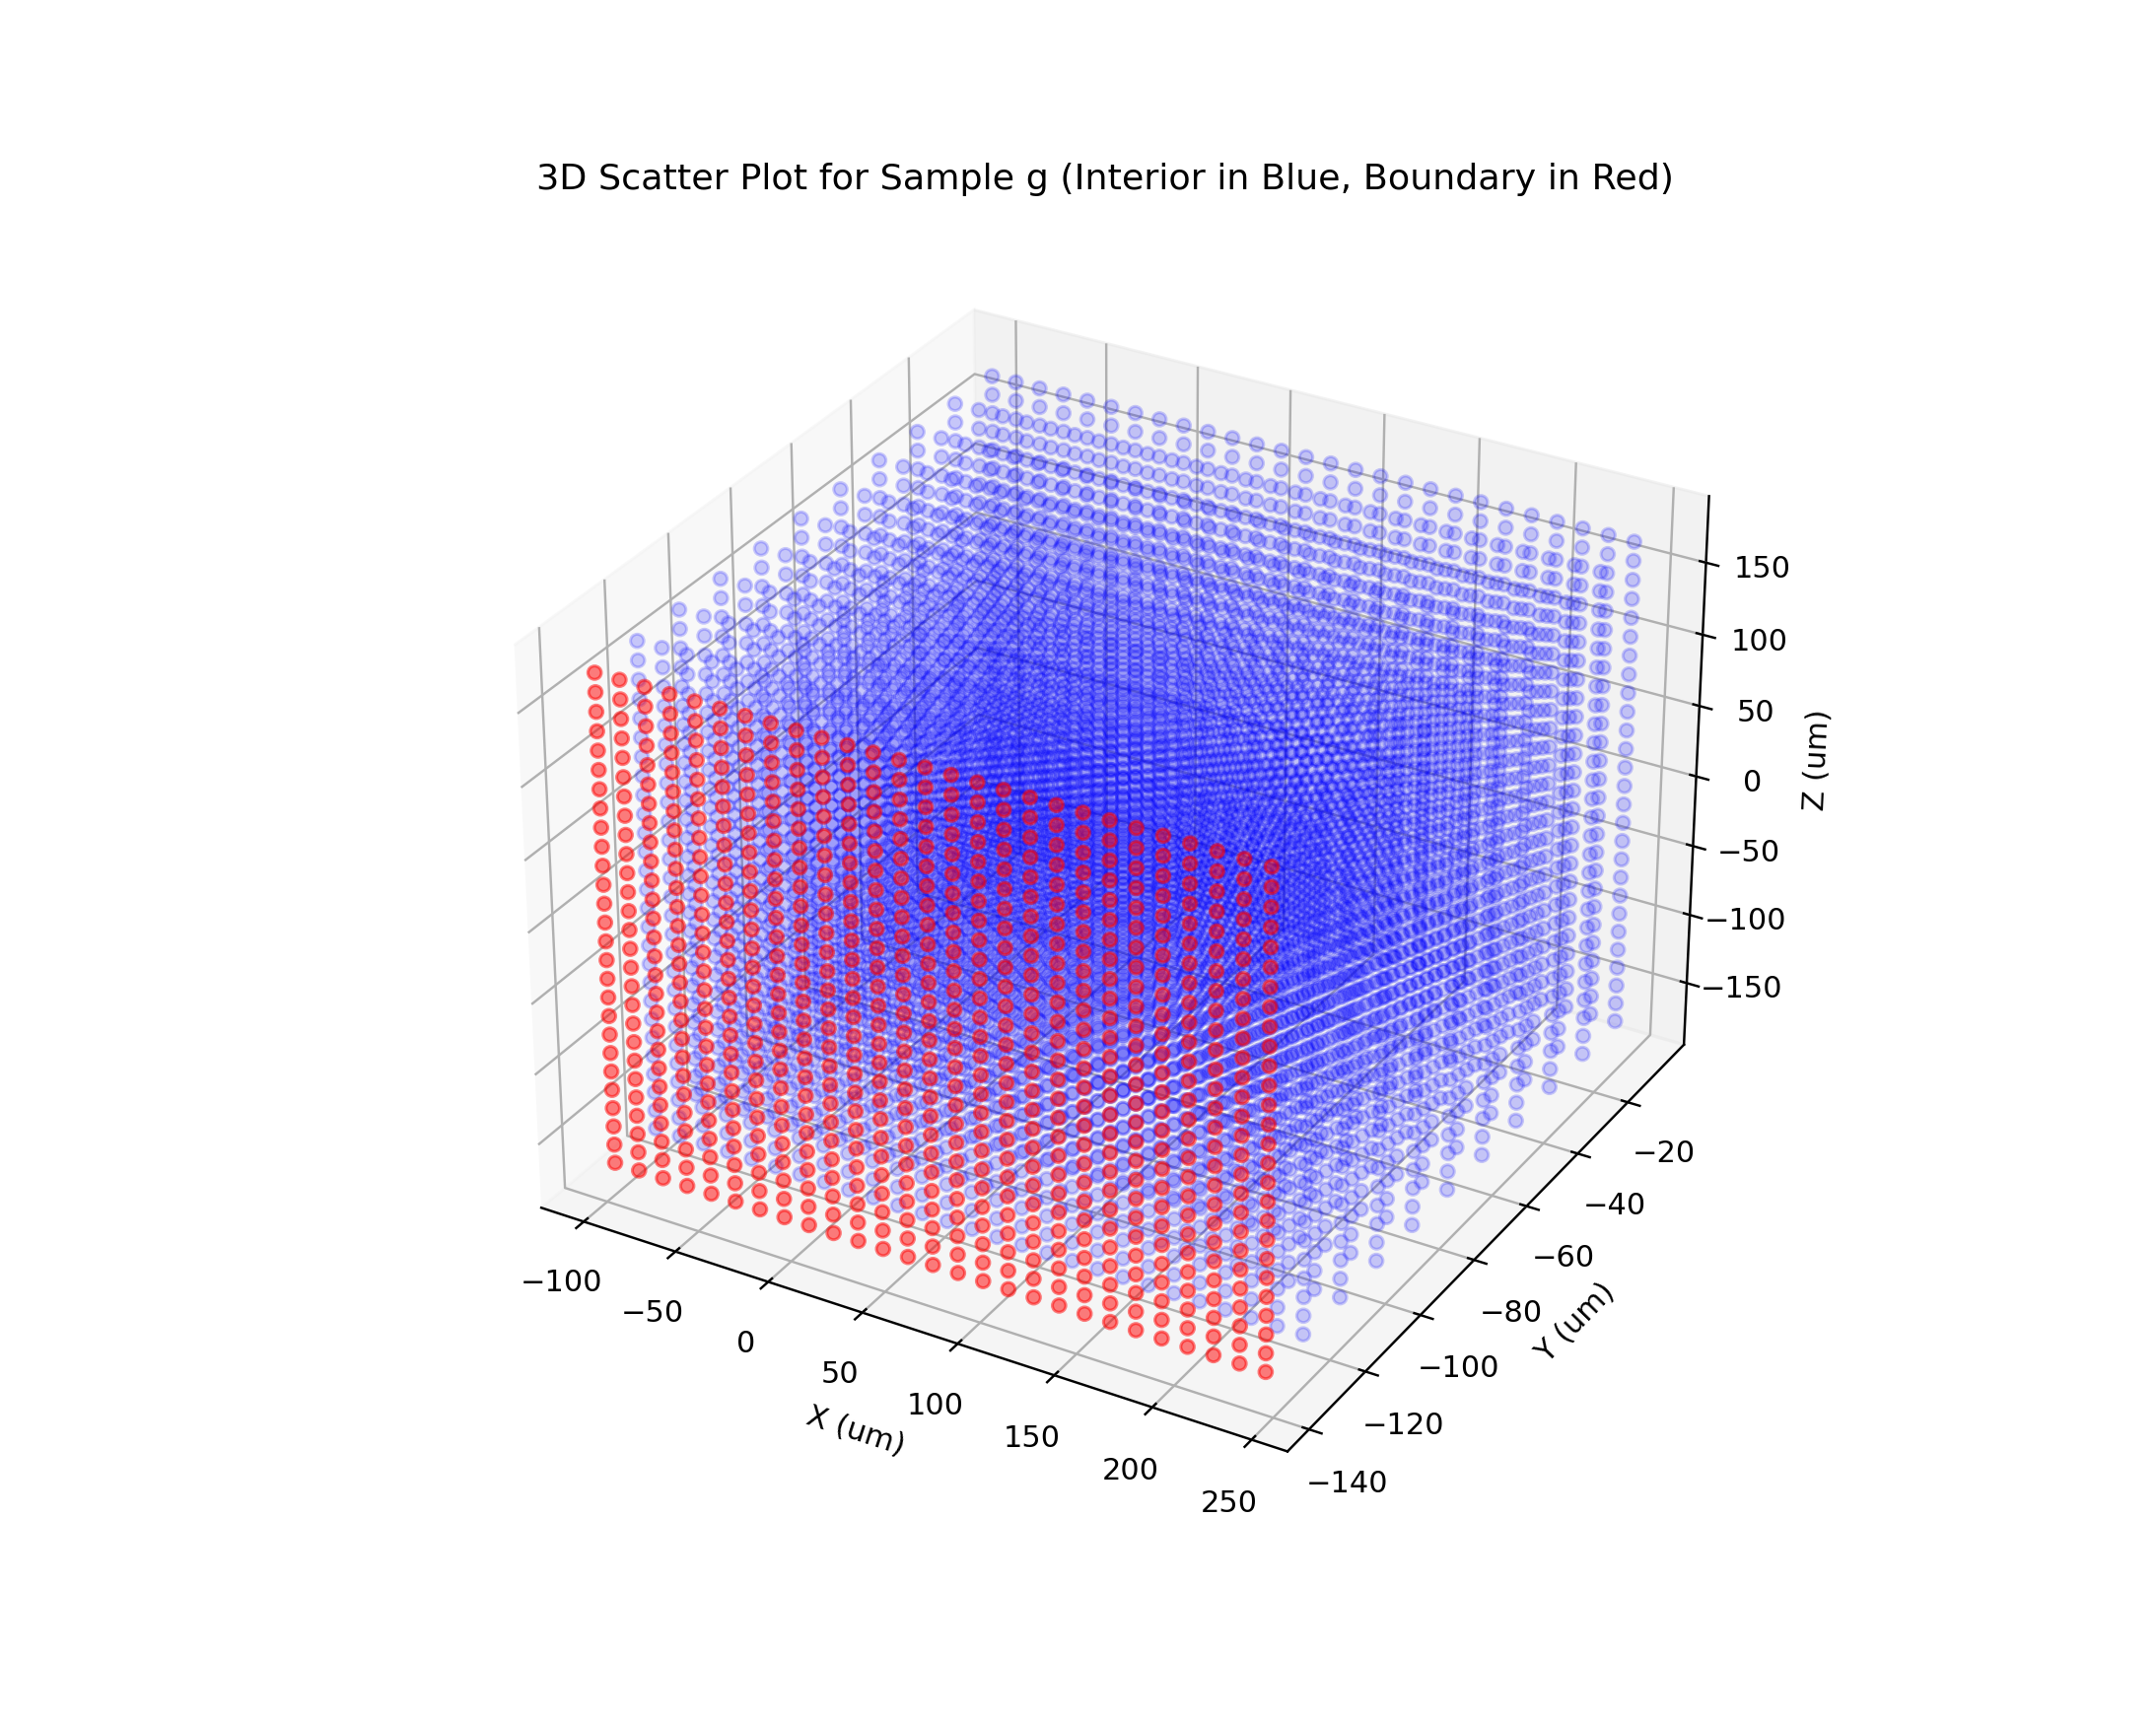

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Loop through each sample and plot the 3D coordinates
for sample in sample_coordinates.keys():
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot in 3D for interior points in blue
    interior_coords = sample_interior_coordinates[sample]
    ax.scatter(interior_coords[:, 0], interior_coords[:, 1], interior_coords[:, 2], c='b', marker='o', alpha=0.2)
    
    # Scatter plot in 3D for boundary points in red
    boundary_coords = sample_boundary_coordinates[sample]
    ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], boundary_coords[:, 2], c='r', marker='o', alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('X (um)')
    ax.set_ylabel('Y (um)')
    ax.set_zlabel('Z (um)')
    ax.set_title(f'3D Scatter Plot for Sample {sample} (Interior in Blue, Boundary in Red)')
    
    plt.show()
    break



In [17]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# # Loop through each sample and plot the 3D coordinates with velocity vectors at z=0
# for sample in sample_coordinates.keys():
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Scatter plot in 3D for interior points in blue
#     interior_coords = sample_interior_coordinates[sample]
#     ax.scatter(interior_coords[:, 0], interior_coords[:, 1], interior_coords[:, 2], c='b', marker='o', alpha=0.1, label='Interior Coordinates')
    
#     # Scatter plot in 3D for boundary points in red
#     boundary_coords = sample_boundary_coordinates[sample]
#     ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], boundary_coords[:, 2], c='r', marker='o', alpha=0.5, label='Boundary Coordinates')
    
#     # Extract data for the sample
#     df_sample = data_frames[sample]
#     x_values = df_sample[variables[0]].values
#     y_values = df_sample[variables[1]].values
#     vx_values = df_sample[variables[2]].values
#     vy_values = df_sample[variables[3]].values
    
#     # Quiver plot for fluid velocity vectors at z=0
#     ax.quiver(x_values, y_values, 0, vx_values, vy_values, 0, color='g', length=0.1, arrow_length_ratio=0.2, label='Velocity Vectors at z=0')
    
#     # Labels and title
#     ax.set_xlabel('X (um)')
#     ax.set_ylabel('Y (um)')
#     ax.set_zlabel('Z (um)')
#     ax.set_title(f'3D Scatter Plot with Velocity Vectors for Sample {sample}')
#     ax.legend()
    
#     plt.show()
#     break


In [18]:
def heat_source(coords: torch.Tensor, power: torch.Tensor, spot_radius: torch.Tensor, eta: torch.Tensor) -> torch.Tensor:
    """
    Computes the heat source based on the input values 
    of x, y, z, power, spot_radius, eta_bulk, eta_powder and O_PD.
    
    Parameters:
        coordinates (torch.Tensor): tensor of coordinate values
        power (torch.Tensor): power value
        eta (torch.Tensor): absorption 
        spot_radius (torch.Tensor): spot radius value (1/e)
    
    Returns:
        Q (torch.Tensor): tensor of heat flux
    """
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    power = power.view(-1)
    
    # Compute the Gaussian heat source
    Q = 2 * (eta * power) / (torch.pi * spot_radius ** 2 * O_PD * torch.sqrt(torch.tensor(torch.pi))) * torch.exp(
        -((x ** 2) / (spot_radius ** 2) + (z ** 2) / (spot_radius ** 2) + (y ** 2) / (O_PD ** 2)))
    
    # Mask to zero out Q values where y is non-negative
    mask = (y >= 0)
    Q[mask] = 0
    
    return Q


<IPython.core.display.Javascript object>


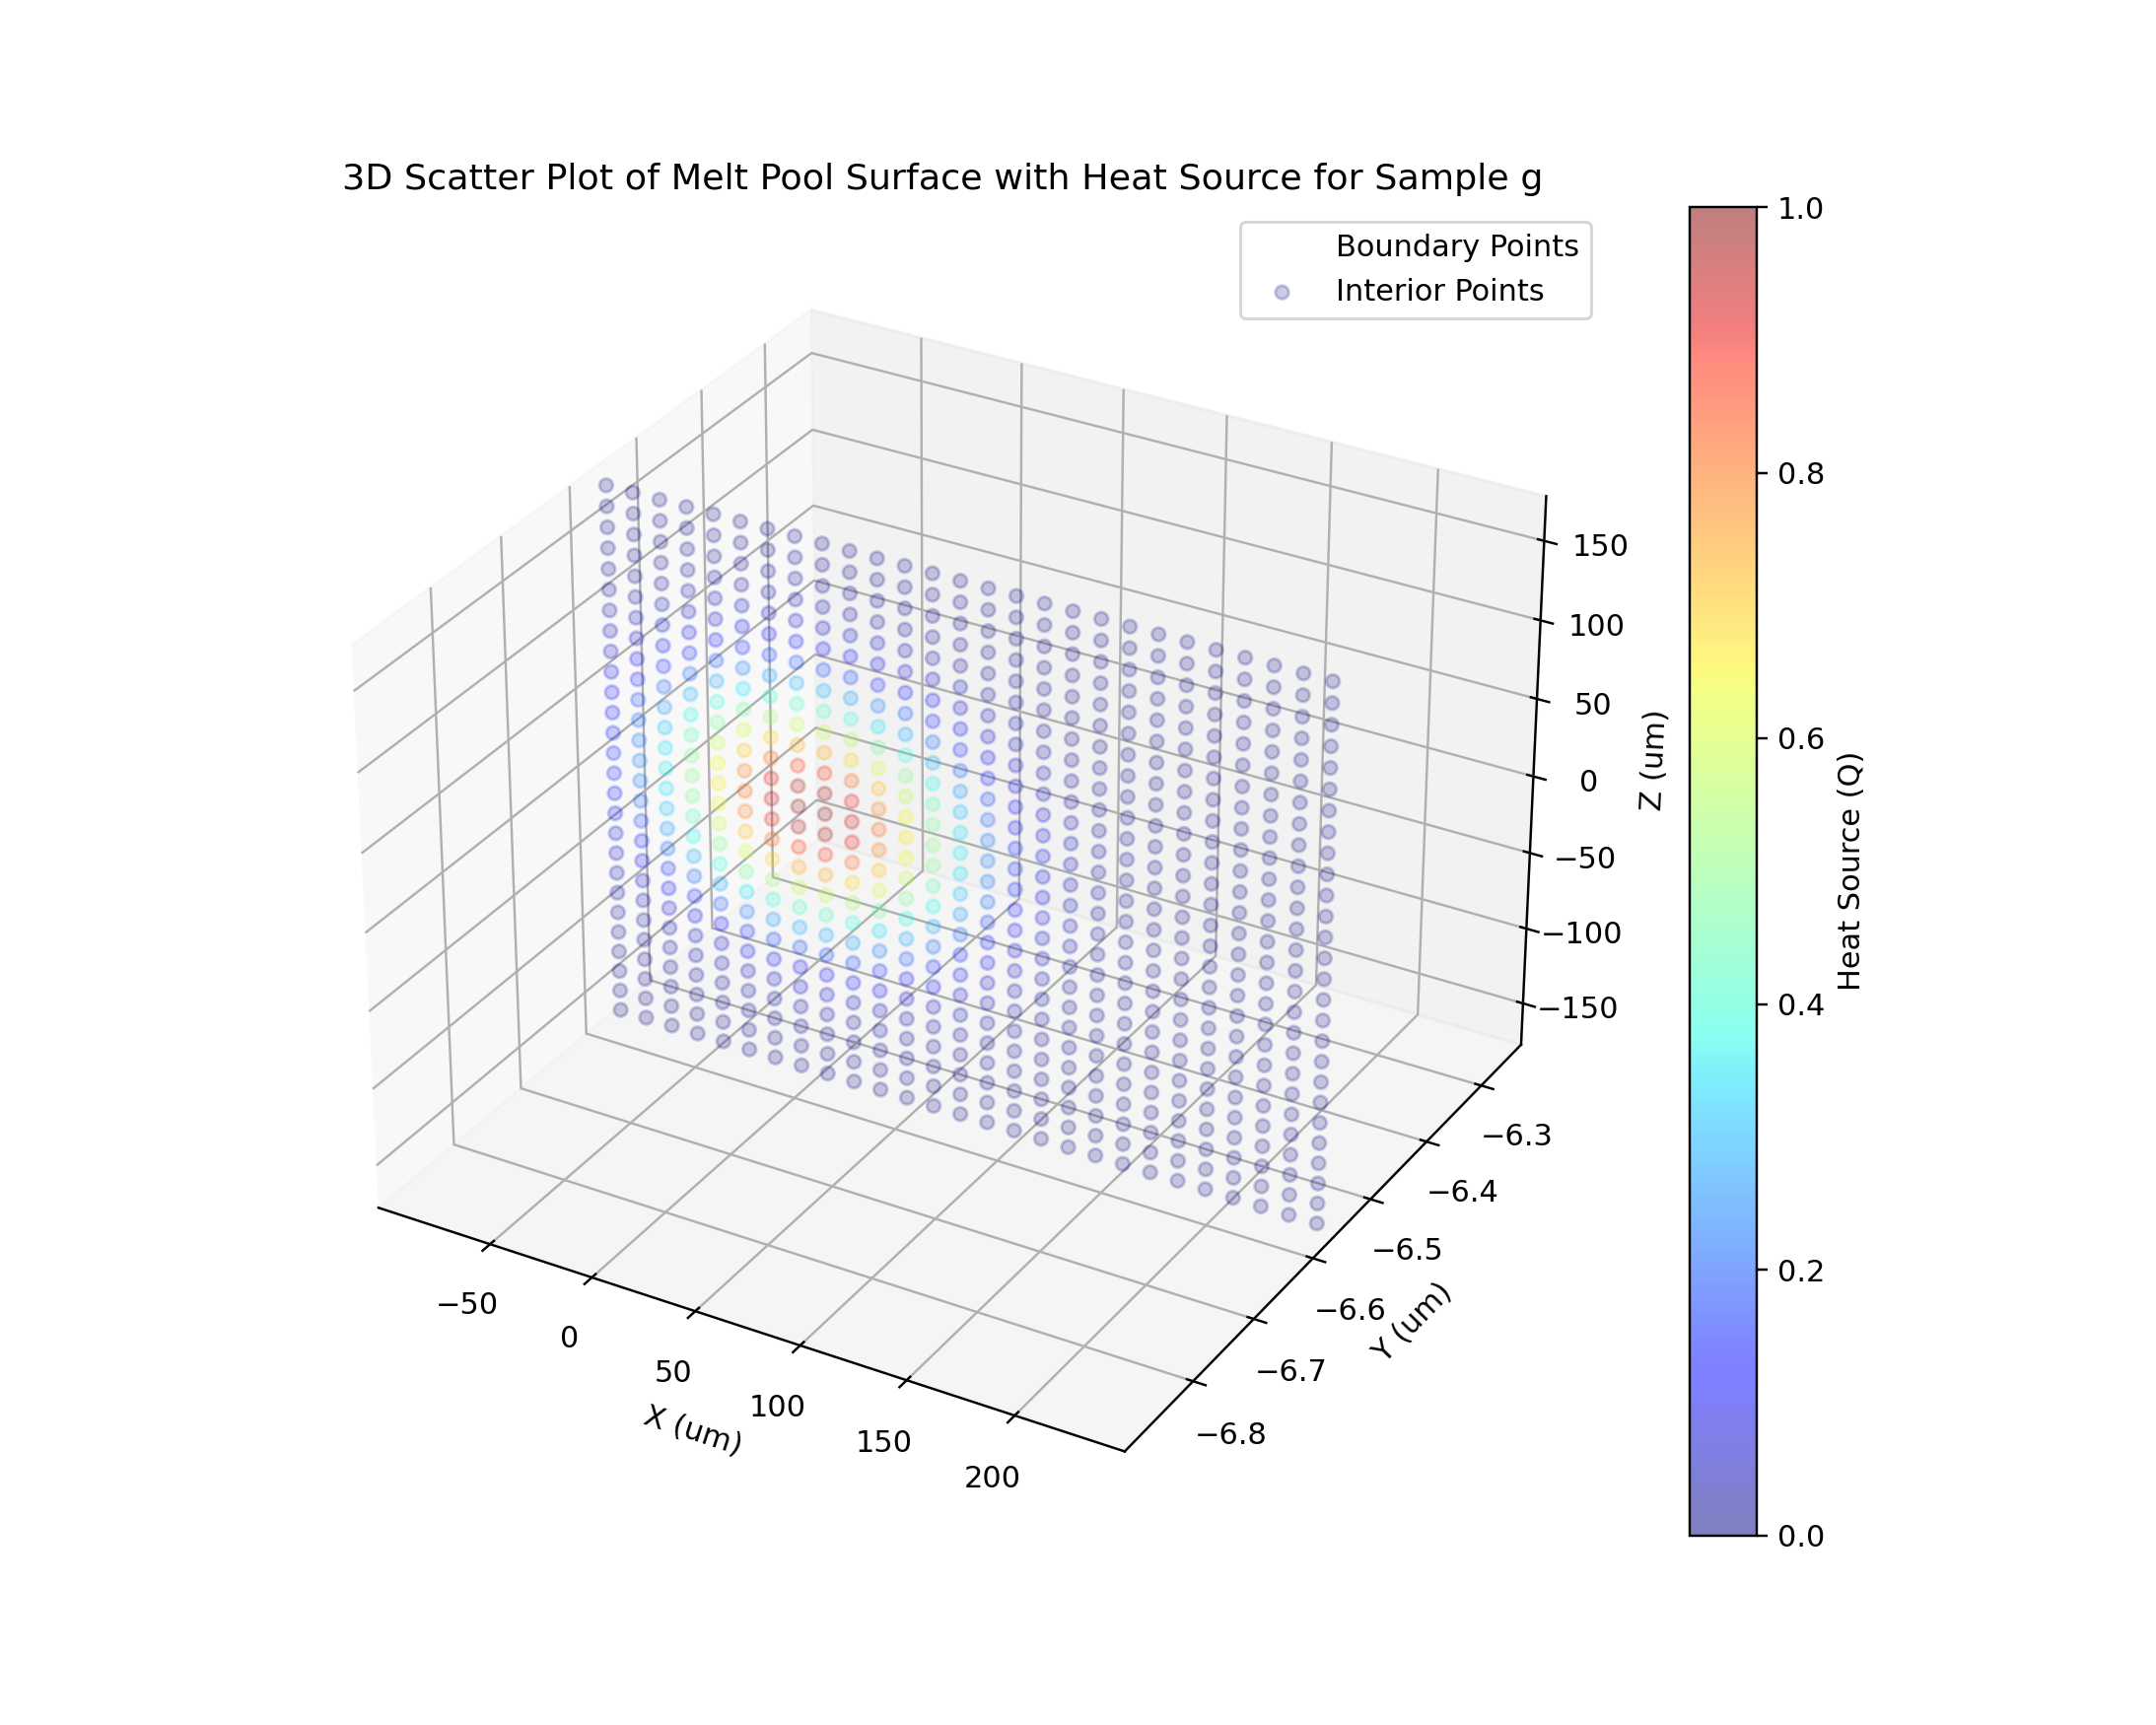

/tmp/ipykernel_3538410/394063617.py:43: UserWarning: Attempting to set identical bottom == top == -6.567500114440918 results in singular transformations; automatically expanding.
  ax.set_ylim([filtered_coords[:, 1].min(), filtered_coords[:, 1].max()])


In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Parameters for heat source (convert them to PyTorch tensors)
power = torch.tensor(global_power_max)

# Loop through each sample and plot the 3D coordinates with heat source
for sample in sample_coordinates.keys():
    # Filter the coordinates to only include the plane with y coordinate closest to 0 and negative
    df_sample = data_frames[sample]
    min_distance_to_zero = np.min(np.abs(df_sample[variables[1]].values))
    closest_to_zero_negative_y = df_sample[np.abs(df_sample[variables[1]].values) == min_distance_to_zero]
    closest_to_zero_negative_y = closest_to_zero_negative_y[closest_to_zero_negative_y[variables[1]] < 0]
    
    filtered_coords = sample_coordinates[sample][(sample_coordinates[sample][:, 1] == closest_to_zero_negative_y[variables[1]].values[0]).nonzero().squeeze(), :]
    boundary_coords = sample_boundary_coordinates[sample][(sample_boundary_coordinates[sample][:, 1] == closest_to_zero_negative_y[variables[1]].values[0]).nonzero().squeeze(), :]
    interior_coords = sample_interior_coordinates[sample][(sample_interior_coordinates[sample][:, 1] == closest_to_zero_negative_y[variables[1]].values[0]).nonzero().squeeze(), :]
    
    # Compute heat source for the boundary and interior coordinates
    Q_values_boundary = heat_source(boundary_coords / 1000, power, spot_radius, eta)
    Q_values_interior = heat_source(interior_coords / 1000, power, spot_radius, eta)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot in 3D colored by heat source values for boundary points
    scatter_boundary = ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], boundary_coords[:, 2], 
                                  c=Q_values_boundary, cmap=cm.jet, marker='x', alpha=0.5, label='Boundary Points')
    
    # Scatter plot in 3D colored by heat source values for interior points
    scatter_interior = ax.scatter(interior_coords[:, 0], interior_coords[:, 1], interior_coords[:, 2], 
                                  c=Q_values_interior, cmap=cm.jet, marker='o', alpha=0.2, label='Interior Points')
 
    
    # Add a color bar to indicate heat source values
    cbar = plt.colorbar(scatter_boundary)
    cbar.set_label('Heat Source (Q)')
    
    # Set axis limits to preserve actual proportions based on the filtered coordinates
    ax.set_xlim([filtered_coords[:, 0].min(), filtered_coords[:, 0].max()])
    ax.set_ylim([filtered_coords[:, 1].min(), filtered_coords[:, 1].max()])
    ax.set_zlim([filtered_coords[:, 2].min(), filtered_coords[:, 2].max()])
    
    # Labels and title
    ax.set_xlabel('X (um)')
    ax.set_ylabel('Y (um)')
    ax.set_zlabel('Z (um)')
    ax.set_title(f'3D Scatter Plot of Melt Pool Surface with Heat Source for Sample {sample}')
    ax.legend()
    
    plt.show()
    break


In [20]:
import torch
import torch.nn as nn

class MultiResidualTempFieldNN(nn.Module):
    def __init__(self, T_amb):
        super(MultiResidualTempFieldNN, self).__init__()
        n_hidden = 2048

        # Define wide but shallow layers
        self.layer1 = nn.Linear(5, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer_out = nn.Linear(n_hidden, 1)

        # Layers for identity transformations
        self.identity1 = nn.Linear(5, n_hidden)  # Matching input dimensions to layer1 output
        self.identity2 = nn.Linear(n_hidden, n_hidden)  # Matching layer1 output to layer2 output

        # Initialize the bias of the output layer to T_amb
        nn.init.constant_(self.layer_out.bias, T_amb)

    def forward(self, x):
        # First layer followed by activation
        x1 = self.layer1(x)
        x1_act = torch.tanh(x1)

        # First residual connection
        identity1_out = self.identity1(x)
        x1_res = x1_act * identity1_out

        # Second layer followed by activation
        x2 = self.layer2(x1_res)
        x2_act = torch.tanh(x2)

        # Second residual connection
        identity2_out = self.identity2(x1_res)
        x2_res = x2_act * identity2_out

        # Output layer
        x_out = self.layer_out(x2_res)
        
        return x_out
    
class MultiResidualTempFieldNN(nn.Module):
    def __init__(self, T_amb):
        super(MultiResidualTempFieldNN, self).__init__()
        n_hidden = 2048

        # Define wide but shallow layers
        self.layer1 = nn.Linear(5, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer_out = nn.Linear(n_hidden, 1)

        # Layers for identity transformations
        self.identity1 = nn.Linear(5, n_hidden)  # Matching input dimensions to layer1 output
        self.identity2 = nn.Linear(n_hidden, n_hidden)  # Matching layer1 output to layer2 output

        # Initialize the bias of the output layer to T_amb
        nn.init.constant_(self.layer_out.bias, T_amb)

    def forward(self, x):
        # First layer followed by activation
        x1 = self.layer1(x)
        x1_act = torch.tanh(x1)

        # First residual connection
        identity1_out = self.identity1(x)
        x1_res = x1_act * identity1_out

        # Second layer followed by activation
        x2 = self.layer2(x1_res)
        x2_act = torch.tanh(x2)

        # Second residual connection
        identity2_out = self.identity2(x1_res)
        x2_res = x2_act * identity2_out

        # Output layer
        x_out = self.layer_out(x2_res)
        
        return x_out


# Fluid Flow Neural Network
class FluidFlowNN(nn.Module):
    def __init__(self):
        super(FluidFlowNN, self).__init__()
        self.layer1 = nn.Linear(5, 2048*4)
        self.layer2 = nn.Linear(2048*4, 512*4)
        self.layer_out = nn.Linear(512*4, 3)
        self.silu = nn.SiLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.silu(x)
        x = self.layer2(x)
        x = self.silu(x)
        x = self.layer_out(x)
        return x

# Instantiate the neural networks
#temp_net = TempFieldNN()
#fluid_net = FluidFlowNN()

# # Print the architectures
# print("Temperature Field Neural Network architecture:")
# print(temp_net)
# print("\nFluid Flow Neural Network architecture:")
# print(fluid_net)


Next steps: 
- write a function to normalize the network input
- output can stay unnormalized 
- write function to generate boundary data at random 
- remember to use cross-validation
- write custom loss 

In [21]:
def normalize_tensor(tensor, min_val, max_val):
    """
    Normalize a tensor to range [-1, 1].

    Parameters:
        tensor (torch.Tensor): The tensor to normalize.
        min_val (float): The minimum value for normalization.
        max_val (float): The maximum value for normalization.

    Returns:
        torch.Tensor: The normalized tensor.
    """
    return ((tensor - min_val) / (max_val - min_val)) * 2 - 1

In [22]:
def normalize_coordinates(tensor, x_min, x_max, y_min, y_max, z_min, z_max):
    normalized_tensor = tensor.clone()  # Create a new tensor
    normalized_tensor[:, 0] = ((tensor[:, 0] - x_min) / (x_max - x_min)) * 2 - 1  # Normalize x
    normalized_tensor[:, 1] = ((tensor[:, 1] - y_min) / (y_max - y_min)) * 2 - 1  # Normalize y
    normalized_tensor[:, 2] = ((tensor[:, 2] - z_min) / (z_max - z_min)) * 2 - 1  # Normalize z
    return normalized_tensor


In [23]:
from torch.utils.data import DataLoader, TensorDataset

# Create a list of sample identifiers
sample_identifiers = list(sample_coordinates.keys())
sample_identifiers

['g', 'd', 'c', 'a', 'e', 'f', 'b']

In [24]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch

# Custom Dataset to handle specific type of data (boundary or interior)
class CustomTensorDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]


def create_data_loader(exclude_sample, x_max, x_min, y_max, y_min, z_max, z_min, 
                       sample_coordinates, sample_boundary_coordinates, sample_interior_coordinates, 
                       conditions_df, data_frames, verbose=False,
                       interior_batch_size=10):
    
    sample_data_loaders = {}
    
    for sample in sample_coordinates.keys():
        
        if verbose:
            print(f"Processing sample: {sample}")
        
        # Get conditions and normalize them
        condition_row = conditions_df[conditions_df['Sample Name'] == sample]
        speed = condition_row['Speed (mm/s)'].values[0]
        power = condition_row['Power (W)'].values[0]
        
        norm_speed = normalize_tensor(torch.tensor([speed]), global_speed_min, global_speed_max)
        norm_power = normalize_tensor(torch.tensor([power]), global_power_min, global_power_max)
        
        # Normalize coordinates
        boundary_coords = normalize_coordinates(sample_boundary_coordinates[sample], x_min, x_max, y_min, y_max, z_min, z_max)
        interior_coords = normalize_coordinates(sample_interior_coordinates[sample], x_min, x_max, y_min, y_max, z_min, z_max)

        # Create condition tensors by repeating the speed and power values
        num_boundary_coords = len(boundary_coords)
        num_interior_coords = len(interior_coords)
        
        condition_boundary = torch.stack([norm_speed.repeat(num_boundary_coords), norm_power.repeat(num_boundary_coords)], dim=1)
        condition_interior = torch.stack([norm_speed.repeat(num_interior_coords), norm_power.repeat(num_interior_coords)], dim=1)
        
        # Concatenate coordinates and conditions
        boundary_data = torch.cat([boundary_coords, condition_boundary], dim=1)
        interior_data = torch.cat([interior_coords, condition_interior], dim=1)
        
        # Create DataLoader for this sample
        boundary_loader = DataLoader(CustomTensorDataset(boundary_data), batch_size=num_boundary_coords, shuffle=True)
        interior_loader = DataLoader(CustomTensorDataset(interior_data), batch_size=interior_batch_size, shuffle=True)
        
        sample_data_loaders[sample] = {'boundary_loader': boundary_loader, 'interior_loader': interior_loader}

    return sample_data_loaders

In [25]:
sample_interior_coordinates['a'].shape

torch.Size([15066, 3])

In [26]:
conditions_df['Sample Name'][0]

'a'

In [27]:
# Create Data Loaders
train_loaders = create_data_loader(conditions_df['Sample Name'][0], global_x_max, global_x_min, global_y_max, 
                                              global_y_min, global_z_max, global_z_min,
                                              sample_coordinates, sample_boundary_coordinates,
                                              sample_interior_coordinates, conditions_df, data_frames)

In [28]:
train_loaders

{'g': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce74f59cc0>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce74f5b7f0>},
 'd': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70632ef0>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70632f20>},
 'c': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce706337f0>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70633d60>},
 'a': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70633490>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70632080>},
 'e': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70630af0>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70630c10>},
 'f': {'boundary_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce70630ca0>,
  'interior_loader': <torch.utils.data.dataloader.DataLoader at 0x7fce7063

In [29]:
def unnormalize_tensor(tensor, min_val, max_val):
    """
    Unnormalize a tensor from range [-1, 1] to original range.

    Parameters:
        tensor (torch.Tensor): The tensor to unnormalize.
        min_val (float): The minimum value for unnormalization.
        max_val (float): The maximum value for unnormalization.

    Returns:
        torch.Tensor: The unnormalized tensor.
    """
    return ((tensor + 1) / 2) * (max_val - min_val) + min_val

def unnormalize_coordinates(tensor, x_min, x_max, y_min, y_max, z_min, z_max):
    """
    Unnormalize the x, y, and z coordinates in a tensor to the original range.

    Parameters:
        tensor (torch.Tensor): The tensor to unnormalize. Shape: [N, 3]
        x_min, x_max (float): The minimum and maximum values for the x-coordinate.
        y_min, y_max (float): The minimum and maximum values for the y-coordinate.
        z_min, z_max (float): The minimum and maximum values for the z-coordinate.

    Returns:
        torch.Tensor: The unnormalized tensor. Shape: [N, 3]
    """
    unnormalized_tensor = tensor.clone()  # Create a new tensor
    unnormalized_tensor[:, 0] = ((tensor[:, 0] + 1) * (x_max - x_min) / 2) + x_min  # Unnormalize x
    unnormalized_tensor[:, 1] = ((tensor[:, 1] + 1) * (y_max - y_min) / 2) + y_min  # Unnormalize y
    unnormalized_tensor[:, 2] = ((tensor[:, 2] + 1) * (z_max - z_min) / 2) + z_min  # Unnormalize z
    
    return unnormalized_tensor


In [30]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Loop through each sample in the training DataLoader
# for i, sample_data in enumerate(train_loader, 0):
#     # Get the boundary and interior data for the current sample
#     boundary_data = sample_data['boundary'][0]
#     interior_data = sample_data['interior'][0]
#     sample_name = sample_data['sample'][0]

#     # Separate the coordinates and conditions
#     boundary_coords = boundary_data[:, :3]
#     boundary_conditions = boundary_data[:, 3:]

#     interior_coords = interior_data[:, :3]
#     interior_conditions = interior_data[:, 3:]

#     # Unnormalize coordinates
#     boundary_coords_unnorm = unnormalize_coordinates(boundary_coords, global_x_min, global_x_max, global_y_min, global_y_max, global_z_min, global_z_max)
#     interior_coords_unnorm = unnormalize_coordinates(interior_coords, global_x_min, global_x_max, global_y_min, global_y_max, global_z_min, global_z_max)

#     # Unnormalize conditions
#     speed_condition = unnormalize_tensor(boundary_conditions[0, 0], global_speed_min, global_speed_max)
#     power_condition = unnormalize_tensor(boundary_conditions[0, 1], global_power_min, global_power_max)

#     # Create the 3D scatter plot
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Plot boundary coordinates in red
#     ax.scatter(boundary_coords_unnorm[:, 0], boundary_coords_unnorm[:, 1], boundary_coords_unnorm[:, 2], c='r', marker='o', alpha=0.5, label='Boundary Coordinates')
    
#     # Plot interior coordinates in blue
#     ax.scatter(interior_coords_unnorm[:, 0], interior_coords_unnorm[:, 1], interior_coords_unnorm[:, 2], c='b', marker='o', alpha=0.1, label='Interior Coordinates')

#     # Labels and title with conditions
#     ax.set_xlabel('X (um)')
#     ax.set_ylabel('Y (um)')
#     ax.set_zlabel('Z (um)')
#     ax.set_title(f'Sample {sample_name} - Speed: {speed_condition} mm/s, Power: {power_condition} W')
#     ax.legend()

#     plt.show()


In [31]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Loop through each batch in the training DataLoader
# for i, sample_data in enumerate(train_loader, 0):
#     # Get the boundary and interior data for the current sample
#     boundary_data = sample_data['boundary'][0]
#     interior_data = sample_data['interior'][0]
#     sample_name = sample_data['sample'][0]

#     # Separate the coordinates and conditions
#     boundary_coords = boundary_data[:, :3]
#     boundary_conditions = boundary_data[:, 3:]

#     interior_coords = interior_data[:, :3]
#     interior_conditions = interior_data[:, 3:]

#     # Extract conditions (no need to unnormalize here)
#     speed_condition = boundary_conditions[0, 0]
#     power_condition = boundary_conditions[0, 1]

#     # Create the 3D scatter plot
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Plot boundary coordinates in red
#     ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], boundary_coords[:, 2], c='r', marker='o', alpha=0.5, label='Boundary Coordinates (Normalized)')
    
#     # Plot interior coordinates in blue
#     ax.scatter(interior_coords[:, 0], interior_coords[:, 1], interior_coords[:, 2], c='b', marker='o', alpha=0.1, label='Interior Coordinates (Normalized)')

#     # Labels and title with conditions
#     ax.set_xlabel('X (Normalized)')
#     ax.set_ylabel('Y (Normalized)')
#     ax.set_zlabel('Z (Normalized)')
#     ax.set_title(f'Sample {sample_name} - Speed: {speed_condition:.4f} (Normalized), Power: {power_condition:.4f} (Normalized)')
#     ax.legend()

#     plt.show()


In [32]:
#temp_net = torch.load('temp_net_trained').cuda()
#temp_net

In [33]:
# Initialize Neural Networks
temp_net = MultiResidualTempFieldNN(300.0).to(device).train()
#temp_net = torch.load('temp_net_trained_ADV_neg')
# Split the model across two GPUs
temp_net = torch.nn.DataParallel(temp_net, device_ids=[0, 1])
temp_net

DataParallel(
  (module): MultiResidualTempFieldNN(
    (layer1): Linear(in_features=5, out_features=2048, bias=True)
    (layer2): Linear(in_features=2048, out_features=2048, bias=True)
    (layer_out): Linear(in_features=2048, out_features=1, bias=True)
    (identity1): Linear(in_features=5, out_features=2048, bias=True)
    (identity2): Linear(in_features=2048, out_features=2048, bias=True)
  )
)

In [34]:
from torch.optim import LBFGS, Adam

# Initialize Optimizers
params = list(temp_net.parameters())
optimizer_adam = Adam(params, lr=1e-4)
optimizer_lbfgs = LBFGS(params, line_search_fn="strong_wolfe")

# Initialize flag to indicate whether the Adam optimizer has been deleted
adam_deleted = False

# Select a single sample for training
single_sample = conditions_df['Sample Name'].tolist()[0]
print(f"Training on single sample: {single_sample}")

# Create Data Loaders
train_loader = create_data_loader(single_sample, global_x_max, global_x_min, global_y_max, 
                                  global_y_min, global_z_max, global_z_min,
                                  sample_coordinates, sample_boundary_coordinates,
                                  sample_interior_coordinates, conditions_df, data_frames,
                                  interior_batch_size=200)

# Unpack the DataLoader for the selected sample
boundary_loader = train_loader[single_sample]['boundary_loader']
interior_loader = train_loader[single_sample]['interior_loader']

# Training loop
for epoch in range(num_epochs):
    loss_epoch = 0.0

    # Boundary Data
    for boundary_data in boundary_loader:
        boundary_data = boundary_data.to(device)
        boundary_data.requires_grad = True

        # Interior Data
        for interior_data in interior_loader:
            interior_data = interior_data.to(device)
            interior_data.requires_grad = True
            
            # Unnormalize conditions
            speed = unnormalize_tensor(interior_data[:, 3], global_speed_min, global_speed_max)
            power = unnormalize_tensor(interior_data[:, 4], global_power_min, global_power_max)
            
            # Unnormalize coordinates
            interior_coords_unnorm = unnormalize_coordinates(interior_data[:, :3], global_x_min, 
                                                             global_x_max, global_y_min, 
                                                             global_y_max, global_z_min, global_z_max)
            
            # Compute heat source for the interior coordinates
            Q_values_interior = heat_source(interior_coords_unnorm / 1000, power, spot_radius, eta)
            optimizer = optimizer_lbfgs
#             # Select the optimizer based on the iteration
#             if epoch < 10:
#                 optimizer = optimizer_adam
#             else:
#                 if not adam_deleted:
#                     # Delete and free memory only once
#                     #del optimizer_adam
#                     #torch.cuda.empty_cache()
#                     adam_deleted = True
#                 optimizer = optimizer_lbfgs
            
            def closure():
                optimizer.zero_grad()
                # Initialize total loss
                total_loss = 0.0

                # Temperature Boundary Computations
                temp_at_boundary = temp_net(boundary_data)

                # Compute temperature gradients at the boundary
                temp_gradients_boundary = torch.autograd.grad(
                    temp_at_boundary.sum(), boundary_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the adiabatic residual at the boundary
                adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
                total_loss += adiabatic_residual_boundary

                # Compute temperature residual at the boundary
                temp_residual_boundary = temp_at_boundary - T_amb
                temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
                total_loss += temp_residual_boundary_mean

                # Temperature Interior Computations
                temp_at_interior = temp_net(interior_data)

                # Compute temperature gradients at the interior
                temp_gradients_interior = torch.autograd.grad(
                    temp_at_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0]

                # Compute second partial derivatives (Laplacian components) for temperature at the interior
                temp_gradients_interior_second = torch.autograd.grad(
                    temp_gradients_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the Laplacian of temperature at the interior
                temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

                # Compute the heat equation residual
                heat_equation_residual = (
                    - rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
                    + kappa * temp_laplacian_interior + Q_values_interior
                )

                # Compute the mean square of the heat equation residual
                heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)*100

                # Add heat equation residual to the total loss
                total_loss += heat_equation_residual_mean

                # Add Penalty for Negative Temperatures
                negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
                negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

                # Add negative temperature penalty to the total loss
                total_loss += negative_temp_penalty_mean

                total_loss.backward(retain_graph=True)
                return total_loss
            
            # Backward pass and optimization
            loss = optimizer.step(closure)
            loss_epoch += loss.item()
            

    print(f"DONE with Epoch: {epoch}, Loss EPOCH: {loss_epoch}")
    
print(f"Finished training on single sample: {single_sample}")


Training on single sample: a
DONE with Epoch: 0, Loss EPOCH: nan


KeyboardInterrupt: 

In [ ]:
#emp_net = torch.load('temp_net_trained_ADV_neg')
# temp_net
temp_net = temp_net.module
 

In [ ]:
temp_net.cpu()

In [ ]:
sample = 'a'
# Get conditions and normalize them
condition_row = conditions_df[conditions_df['Sample Name'] == sample]
speed = condition_row['Speed (mm/s)'].values[0]
power = condition_row['Power (W)'].values[0]

norm_speed = normalize_tensor(torch.tensor([speed]), global_speed_min, global_speed_max)
norm_power = normalize_tensor(torch.tensor([power]), global_power_min, global_power_max)
        
# Normalize coordinates
boundary_coords = normalize_coordinates(sample_boundary_coordinates[sample], global_x_min, global_x_max, global_y_min, global_y_max, global_z_min, global_z_max)
interior_coords = normalize_coordinates(sample_interior_coordinates[sample], global_x_min, global_x_max, global_y_min, global_y_max, global_z_min, global_z_max)

# Create condition tensors by repeating the speed and power values
num_boundary_coords = len(boundary_coords)
num_interior_coords = len(interior_coords)

condition_boundary = torch.stack([norm_speed.repeat(num_boundary_coords), norm_power.repeat(num_boundary_coords)], dim=1)
condition_interior = torch.stack([norm_speed.repeat(num_interior_coords), norm_power.repeat(num_interior_coords)], dim=1)

# Concatenate coordinates and conditions
boundary_data = torch.cat([boundary_coords, condition_boundary], dim=1)
interior_data = torch.cat([interior_coords, condition_interior], dim=1)

boundary_data.requires_grad = True
interior_data.requires_grad = True

In [ ]:
# Unnormalize conditions
speed = unnormalize_tensor(interior_data[:, 3], global_speed_min, global_speed_max)
power = unnormalize_tensor(interior_data[:, 4], global_power_min, global_power_max)

# Unnormalize coordinates
interior_coords_unnorm = unnormalize_coordinates(interior_data[:, :3], global_x_min, 
                                                 global_x_max, global_y_min, 
                                                 global_y_max, global_z_min, global_z_max)

# Compute heat source for the interior coordinates
Q_values_interior = heat_source(interior_coords_unnorm / 1000, power, spot_radius, eta)


In [ ]:
total_loss = 0.0

#temp_net = temp_net.cpu().module
# Temperature Boundary Computations
temp_at_boundary = temp_net(boundary_data.cpu())

# Compute temperature gradients at the boundary
temp_gradients_boundary = torch.autograd.grad(
    temp_at_boundary.sum(), boundary_data,
    create_graph=True, retain_graph=True
)[0][:, :3]

# Compute the adiabatic residual at the boundary
adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
total_loss += adiabatic_residual_boundary

# Compute temperature residual at the boundary
temp_residual_boundary = temp_at_boundary - T_amb
temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
total_loss += temp_residual_boundary_mean

# Temperature Interior Computations
temp_at_interior = temp_net(interior_data.cpu())

# Compute temperature gradients at the interior
temp_gradients_interior = torch.autograd.grad(
    temp_at_interior.sum(), interior_data,
    create_graph=True, retain_graph=True
)[0]

# Compute second partial derivatives (Laplacian components) for temperature at the interior
temp_gradients_interior_second = torch.autograd.grad(
    temp_gradients_interior.sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][:, :3]

# Compute the Laplacian of temperature at the interior
temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

# Compute the heat equation residual
heat_equation_residual = (
    - rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
    + kappa * temp_laplacian_interior + Q_values_interior
)

# Compute the mean square of the heat equation residual
heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)

# Add heat equation residual to the total loss
total_loss += heat_equation_residual_mean

# Add Penalty for Negative Temperatures
negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

# Add negative temperature penalty to the total loss
total_loss += negative_temp_penalty_mean
# Print each component of the total loss for debugging and analysis
print("Component-wise Loss Contributions:")
print(f"Adiabatic Residual at Boundary: {adiabatic_residual_boundary.item():.6f}")
print(f"Temperature Residual at Boundary: {temp_residual_boundary_mean.item():.6f}")
print(f"Heat Equation Residual: {heat_equation_residual_mean.item():.6f}")
print(f"Negative Temperature Penalty: {negative_temp_penalty_mean.item():.6f}")
print(f"Total Loss: {total_loss.item():.6f}")


In [ ]:
Q_values_interior

In [ ]:
inner = temp_gradients_interior[:, 0] * speed.flatten()
inner.shape, inner.max()

In [ ]:
temp_gradients_interior[:, 0].shape

In [ ]:
device = 'cpu'

In [ ]:
temp = temp_net(interior_data)
temp.max(), speed, power, Q_values_interior.max()

In [ ]:
temp.mean()

In [ ]:
interior_coords_unnorm[:, 1]

In [ ]:
%matplotlib 

In [ ]:
# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = interior_coords_unnorm[:, 0].cpu().detach().numpy(), interior_coords_unnorm[:, 1].cpu().detach().numpy(), interior_coords_unnorm[:, 2].cpu().detach().numpy()

scatter = ax.scatter(x, y, z, c=Q_values_interior.cpu().detach().numpy(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Source')

plt.show()

In [ ]:
# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = interior_coords_unnorm[:, 0].cpu().detach().numpy(), interior_coords_unnorm[:, 1].cpu().detach().numpy(), interior_coords_unnorm[:, 2].cpu().detach().numpy()

scatter = ax.scatter(x, y, z, c=temp.cpu().detach().numpy(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Temperature Field')

plt.show()

In [ ]:
# Find the maximum Y value
y_max = np.max(y)

# Create a mask for the points that are on the plane y = y_max
mask_y_max = (y == y_max)

# Filter the x, y, z coordinates and the adv values
x_filtered = x[mask_y_max]
y_filtered = y[mask_y_max]
z_filtered = z[mask_y_max]

adv = rho * Cp * temp_gradients_interior[:, 0].cpu() * speed.flatten().cpu()
adv_filtered = adv.cpu().detach().numpy()[mask_y_max]

# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Only plot the points that lie on the plane y = y_max
scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=adv_filtered, cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Advection term on the plane y = y_max')

plt.show()

print("Maximum value of advection term:", np.max(adv_filtered))


In [ ]:
# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface_data = interior_data[interior_data[:,1] == interior_data[:,1].max()]
temp_surface = temp_net(surface_data.cpu())

x, y, z = surface_data[:, 0].cpu().detach().numpy(), surface_data[:, 1].cpu().detach().numpy(), surface_data[:, 2].cpu().detach().numpy()

scatter = ax.scatter(x, y, z, c=temp_surface.cpu().detach().view(-1).numpy(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Temperature Field')

plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate Y-Z grid
y_values = np.linspace(-2, 2, 100)
z_values = np.linspace(-2, 2, 100)
y_grid, z_grid = np.meshgrid(y_values, z_values)

# Prepare the data for the neural network
x_fixed = - np.ones_like(y_grid)  # X-coordinate is fixed at 1
norm_speed = np.full_like(y_grid, interior_data[0, 3].detach())  # Normalized speed
norm_power = np.full_like(y_grid, interior_data[0, 4].detach())  # Normalized power

# Reshape the data and concatenate all columns
nn_input = np.stack([x_fixed.ravel(), y_grid.ravel(), z_grid.ravel(), norm_speed.ravel(), norm_power.ravel()], axis=1)

# Convert to PyTorch tensor
nn_input_tensor = torch.tensor(nn_input, dtype=torch.float32)

# Evaluate the temperature field using the neural network
with torch.no_grad():
    temp_field = temp_net(nn_input_tensor).cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nn_input[:, 0], nn_input[:, 1], nn_input[:, 2], c=temp_field.ravel(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Temperature Field in Y-Z Plane at X=-1')

plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate X-Z grid
x_values = np.linspace(-6, 2, 100)
z_values = np.linspace(-2, 2, 100)
x_grid, z_grid = np.meshgrid(x_values, z_values)

# Prepare the data for the neural network
y_fixed = np.ones_like(x_grid)  # Y-coordinate is fixed at 1
norm_speed = np.full_like(x_grid, interior_data[0, 3].detach())  # Normalized speed
norm_power = np.full_like(x_grid, interior_data[0, 4].detach())  # Normalized power

# Reshape the data and concatenate all columns
nn_input = np.stack([x_grid.ravel(), y_fixed.ravel(), z_grid.ravel(), norm_speed.ravel(), norm_power.ravel()], axis=1)

# Convert to PyTorch tensor
nn_input_tensor = torch.tensor(nn_input, dtype=torch.float32)

# Evaluate the temperature field using the neural network
with torch.no_grad():
    temp_field = temp_net(nn_input_tensor).cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(nn_input[:, 0], nn_input[:, 1], nn_input[:, 2], c=temp_field.ravel(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Temperature Field in X-Z Plane at Y=1')

plt.show()


In [ ]:
torch.save(temp_net, 'temp_net_trained')

In [ ]:
nn_input

In [ ]:
# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot interior_data points
x_interior, y_interior, z_interior = interior_data[:, 0].cpu().detach().numpy(), interior_data[:, 1].cpu().detach().numpy(), interior_data[:, 2].cpu().detach().numpy()
scatter_interior = ax.scatter(x_interior, y_interior, z_interior, c=temp.cpu().detach().numpy(), cmap='coolwarm')

# Plot boundary_data points in red
x_boundary, y_boundary, z_boundary = boundary_data[:, 0].cpu().detach().numpy(), boundary_data[:, 1].cpu().detach().numpy(), boundary_data[:, 2].cpu().detach().numpy()
scatter_boundary = ax.scatter(x_boundary, y_boundary, z_boundary, c='red', label='Boundary Data')

# Add a colorbar to indicate temperature values for the interior points
cbar = fig.colorbar(scatter_interior, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

# Label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add title
plt.title('Temperature Field')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Find the maximum Y value
y_max = np.max(y)

# Create a mask for the points that are on the plane y = y_max
mask_y_max = (y == y_max)

# Filter the x, y, z coordinates and the adv values
x_filtered = x[mask_y_max]
y_filtered = y[mask_y_max]
z_filtered = z[mask_y_max]

adv = rho * Cp * temp_gradients_interior[:, 0].cpu() * speed.flatten().cpu()
adv_filtered = adv.cpu().detach().numpy()[mask_y_max]

# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Only plot the points that lie on the plane y = y_max
scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=adv_filtered, cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Advection term on the plane y = y_max')

plt.show()

print("Maximum value of advection term:", np.max(adv_filtered))


In [ ]:
# Find the maximum Y value
y_max = np.max(y)

# Create a mask for the points that are on the plane y = y_max
mask_y_max = (y == y_max)

# Filter the x, y, z coordinates and the diff values
x_filtered = x[mask_y_max]
y_filtered = y[mask_y_max]
z_filtered = z[mask_y_max]
diff = kappa * temp_laplacian_interior
diff_filtered = diff.cpu().detach().numpy()[mask_y_max]

# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Only plot the points that lie on the plane y = y_max
scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=diff_filtered, cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Q')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Diffusion term on the plane y = y_max')

plt.show()

print("Maximum value of diffusion term:", np.max(diff_filtered))


In [ ]:
# Compute the heat equation residual
heat_equation_residual = (
    rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
    - kappa * temp_laplacian_interior - Q_values_interior
)

In [ ]:
from torch.optim import LBFGS, Adam

# Initialize Neural Networks
temp_net = TempFieldNN().to(device).train()
fluid_net = FluidFlowNN().to(device).train()

# Initialize L-BFGS Optimizer
params = list(temp_net.parameters()) + list(fluid_net.parameters())
optimizer = Adam(params, lr=1e-3) #LBFGS(params, line_search_fn="strong_wolfe")

# Loss function
criterion = nn.MSELoss()

# List of all sample names
all_samples = conditions_df['Sample Name'].tolist()

# Leave-One-Out Cross-Validation
for exclude_sample in all_samples:
    print(f"Excluding sample: {exclude_sample} for validation.")

    # Create Data Loaders
    train_loader, val_loader = create_data_loader(exclude_sample, global_x_max, global_x_min, global_y_max, 
                                                  global_y_min, global_z_max, global_z_min,
                                                  sample_coordinates, sample_boundary_coordinates,
                                                  sample_interior_coordinates, conditions_df, data_frames)
    
    # Inner training loop
    for epoch in range(num_epochs):  
        loss_epoch = 0.0
        for i, sample_data in enumerate(train_loader, 0):
            boundary_data = sample_data['boundary'][0].to(device)
            interior_data = sample_data['interior'][0].to(device)
            sample_name = sample_data['sample'][0]
            
            # Unnormalize conditions
            speed = unnormalize_tensor(interior_data[:, 3], global_speed_min, global_speed_max)
            power = unnormalize_tensor(interior_data[:, 4], global_power_min, global_power_max)
            
            # Unnormalize coordinates
            interior_coords_unnorm = unnormalize_coordinates(interior_data[:, :3], global_x_min, 
                                                             global_x_max, global_y_min, 
                                                             global_y_max, global_z_min, global_z_max)

            print(f"Processing sample: {sample_name}")

            # Set the coordinates to require gradient computation
            boundary_data.requires_grad = True
            interior_data.requires_grad = True
            
            # Compute heat source for the interior coordinates
            Q_values_interior = heat_source(interior_coords_unnorm / 1000, power, spot_radius, eta)     

            def closure():
                optimizer.zero_grad()
                # Initialize total loss
                total_loss = 0.0

                # Temperature Boundary Computations
                temp_at_boundary = temp_net(boundary_data)

                # Compute temperature gradients at the boundary
                temp_gradients_boundary = torch.autograd.grad(
                    temp_at_boundary.sum(), boundary_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the adiabatic residual at the boundary
                adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
                total_loss += adiabatic_residual_boundary

                # Compute temperature residual at the boundary
                temp_residual_boundary = temp_at_boundary - T_amb
                temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
                total_loss += temp_residual_boundary_mean

                # Fluid Boundary Computations
                fluid_at_boundary = fluid_net(boundary_data)

                # Compute fluid residual at the boundary
                fluid_residual_boundary = torch.mean(fluid_at_boundary ** 2)
                total_loss += fluid_residual_boundary

                # Temperature Interior Computations
                temp_at_interior = temp_net(interior_data)

                # Compute temperature gradients at the interior
                temp_gradients_interior = torch.autograd.grad(
                    temp_at_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0]

                # Compute second partial derivatives (Laplacian components) for temperature at the interior
                temp_gradients_interior_second = torch.autograd.grad(
                    temp_gradients_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the Laplacian of temperature at the interior
                temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

                # Fluid Interior Computations
                fluid_at_interior = fluid_net(interior_data)

                # Find Minimum Y-Coordinate for Surface (Still Negative)
                interior_coordinates = interior_data[:, :3]
                min_y_surface = interior_coordinates[:, 1][interior_coordinates[:, 1] < 0].max()

                # Create Mask for Surface (Smallest Y but Still Negative)
                mask_surface = (interior_coordinates[:, 1] == min_y_surface)

                # Create Mask for Temperature Greater Than Melting Point
                mask_temp_above_melt = (temp_at_interior > T_melt).view(-1)

                # Combine Both Masks
                mask_surface_and_above_melt = mask_surface.view(-1) & mask_temp_above_melt.view(-1)

                # Compute X-Component Fluid Gradients at Surface and Above Melting Point
                fluid_gradients_x = torch.autograd.grad(
                    fluid_at_interior[:, 0].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Compute Z-Component Fluid Gradients at Surface and Above Melting Point
                fluid_gradients_z = torch.autograd.grad(
                    fluid_at_interior[:, 2].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Compute Temperature Gradients at Surface and Above Melting Point
                temp_gradients_surface_melt = torch.autograd.grad(
                    temp_at_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Marangoni Constraint 1
                if fluid_gradients_x.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
                    # print("Warning: Either fluid_gradients_x or temp_gradients_surface_melt is empty for constraint_marangoni_1, setting its contribution to zero.")
                    constraint_marangoni_1_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_x.device)  # Make sure it's on the same device
                else:
                    constraint_marangoni_1 = mu * fluid_gradients_x[:, 1] - temp_gradients_surface_melt[:, 0] * dgamma_dt
                    constraint_marangoni_1_mean_squared = torch.mean(constraint_marangoni_1 ** 2)
                # Add to total loss
                total_loss += constraint_marangoni_1_mean_squared

                # Marangoni Constraint 2
                if fluid_gradients_z.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
                    # print("Warning: Either fluid_gradients_z or temp_gradients_surface_melt is empty for constraint_marangoni_2, setting its contribution to zero.")
                    constraint_marangoni_2_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_z.device)  # Make sure it's on the same device
                else:
                    constraint_marangoni_2 = mu * fluid_gradients_z[:, 1] - temp_gradients_surface_melt[:, 2] * dgamma_dt
                    constraint_marangoni_2_mean_squared = torch.mean(constraint_marangoni_2 ** 2)
                # Add to total loss
                total_loss += constraint_marangoni_2_mean_squared

                # No Vertical Fluid Velocity at the Surface
                total_loss += torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2)

                # No Fluid Flow Outside Liquid Phase
                mask_temp_below_melt = ~mask_temp_above_melt.view(-1)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 1] ** 2)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 2] ** 2)

                # Compute Fluid Divergence
                fluid_gradients_vx = torch.autograd.grad(
                    fluid_at_interior[:, 0].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 0]

                fluid_gradients_vy = torch.autograd.grad(
                    fluid_at_interior[:, 1].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 1]

                fluid_gradients_vz = torch.autograd.grad(
                    fluid_at_interior[:, 2].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 2]

                # Compute Divergence: div(V) = dVx/dx + dVy/dy + dVz/dz
                fluid_divergence = fluid_gradients_vx + fluid_gradients_vy + fluid_gradients_vz

                # Enforce Zero Divergence for Fluid
                total_loss += torch.mean(fluid_divergence ** 2)

                # Compute inner product between temperature gradients and fluid velocity in the interior
                inner_product_temp_gradients_fluid_velocity = (temp_gradients_interior[:, :3] * fluid_at_interior).sum(dim=1)

                # Compute the heat equation residual
                heat_equation_residual = (
                    rho * Cp * inner_product_temp_gradients_fluid_velocity
                    - rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
                    - kappa * temp_laplacian_interior - Q_values_interior
                )

                # Compute the mean square of the heat equation residual
                heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)

                # Add heat equation residual to the total loss
                total_loss += heat_equation_residual_mean

                # Add Penalty for Negative Temperatures
                negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
                negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

                # Add negative temperature penalty to the total loss
                total_loss += negative_temp_penalty_mean
                
                total_loss.backward()
                
                # Print each component of the total loss for debugging and analysis
#                 print("Component-wise Loss Contributions:")
#                 print(f"Adiabatic Residual at Boundary: {adiabatic_residual_boundary.item():.6f}")
#                 print(f"Temperature Residual at Boundary: {temp_residual_boundary_mean.item():.6f}")
#                 print(f"Fluid Residual at Boundary: {fluid_residual_boundary.item():.6f}")
#                 print(f"Marangoni Constraint 1: {constraint_marangoni_1_mean_squared.item():.6f}")
#                 print(f"Marangoni Constraint 2: {constraint_marangoni_2_mean_squared.item():.6f}")
#                 print(f"Vertical Fluid Velocity at Surface: {torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2).item():.6f}")
#                 print(f"Fluid Flow Outside Liquid Phase: {torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2).item():.6f}")
#                 print(f"Fluid Divergence: {torch.mean(fluid_divergence ** 2).item():.6f}")
#                 print(f"Heat Equation Residual: {heat_equation_residual_mean.item():.6f}")
#                 print(f"Negative Temperature Penalty: {negative_temp_penalty_mean.item():.6f}")
#                 print(f"Total Loss: {total_loss.item():.6f}")
                
                
                return total_loss

            # Backward pass and optimization using L-BFGS
            loss = optimizer.step(closure)
            loss_epoch += loss.item()
            
            #print(f"Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}")
            print("-------"*8)
            
        print(f"DONE with Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}, Loss EPOCH: {loss_epoch}")    
    print(f"Finished LOOCV for excluded sample: {exclude_sample}")

print("Finished all LOOCV cycles.")


In [ ]:
# Initialize L-BFGS Optimizer
params = list(temp_net.parameters()) + list(fluid_net.parameters())
optimizer = LBFGS(params, line_search_fn="strong_wolfe", max_iter=2500)

# Loss function
criterion = nn.MSELoss()

# List of all sample names
all_samples = conditions_df['Sample Name'].tolist()

# Leave-One-Out Cross-Validation
for exclude_sample in all_samples:
    print(f"Excluding sample: {exclude_sample} for validation.")

    # Create Data Loaders
    train_loader, val_loader = create_data_loader(exclude_sample, global_x_max, global_x_min, global_y_max, 
                                                  global_y_min, global_z_max, global_z_min,
                                                  sample_coordinates, sample_boundary_coordinates,
                                                  sample_interior_coordinates, conditions_df, data_frames)
    
    # Inner training loop
    for epoch in range(num_epochs):  
        loss_epoch = 0.0
        for i, sample_data in enumerate(train_loader, 0):
            boundary_data = sample_data['boundary'][0].to(device)
            interior_data = sample_data['interior'][0].to(device)
            sample_name = sample_data['sample'][0]
            
            # Unnormalize conditions
            speed = unnormalize_tensor(interior_data[:, 3], global_speed_min, global_speed_max)
            power = unnormalize_tensor(interior_data[:, 4], global_power_min, global_power_max)
            
            # Unnormalize coordinates
            interior_coords_unnorm = unnormalize_coordinates(interior_data[:, :3], global_x_min, 
                                                             global_x_max, global_y_min, 
                                                             global_y_max, global_z_min, global_z_max)

            print(f"Processing sample: {sample_name}")

            # Set the coordinates to require gradient computation
            boundary_data.requires_grad = True
            interior_data.requires_grad = True
            
            # Compute heat source for the interior coordinates
            Q_values_interior = heat_source(interior_coords_unnorm / 1000, power, spot_radius, eta)     

            def closure():
                optimizer.zero_grad()
                # Initialize total loss
                total_loss = 0.0

                # Temperature Boundary Computations
                temp_at_boundary = temp_net(boundary_data)

                # Compute temperature gradients at the boundary
                temp_gradients_boundary = torch.autograd.grad(
                    temp_at_boundary.sum(), boundary_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the adiabatic residual at the boundary
                adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
                total_loss += adiabatic_residual_boundary

                # Compute temperature residual at the boundary
                temp_residual_boundary = temp_at_boundary - T_amb
                temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
                total_loss += temp_residual_boundary_mean

                # Fluid Boundary Computations
                fluid_at_boundary = fluid_net(boundary_data)

                # Compute fluid residual at the boundary
                fluid_residual_boundary = torch.mean(fluid_at_boundary ** 2)
                total_loss += fluid_residual_boundary

                # Temperature Interior Computations
                temp_at_interior = temp_net(interior_data)

                # Compute temperature gradients at the interior
                temp_gradients_interior = torch.autograd.grad(
                    temp_at_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0]

                # Compute second partial derivatives (Laplacian components) for temperature at the interior
                temp_gradients_interior_second = torch.autograd.grad(
                    temp_gradients_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, :3]

                # Compute the Laplacian of temperature at the interior
                temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

                # Fluid Interior Computations
                fluid_at_interior = fluid_net(interior_data)

                # Find Minimum Y-Coordinate for Surface (Still Negative)
                interior_coordinates = interior_data[:, :3]
                min_y_surface = interior_coordinates[:, 1][interior_coordinates[:, 1] < 0].max()

                # Create Mask for Surface (Smallest Y but Still Negative)
                mask_surface = (interior_coordinates[:, 1] == min_y_surface)

                # Create Mask for Temperature Greater Than Melting Point
                mask_temp_above_melt = (temp_at_interior > T_melt).view(-1)

                # Combine Both Masks
                mask_surface_and_above_melt = mask_surface.view(-1) & mask_temp_above_melt.view(-1)

                # Compute X-Component Fluid Gradients at Surface and Above Melting Point
                fluid_gradients_x = torch.autograd.grad(
                    fluid_at_interior[:, 0].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Compute Z-Component Fluid Gradients at Surface and Above Melting Point
                fluid_gradients_z = torch.autograd.grad(
                    fluid_at_interior[:, 2].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Compute Temperature Gradients at Surface and Above Melting Point
                temp_gradients_surface_melt = torch.autograd.grad(
                    temp_at_interior.sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][mask_surface_and_above_melt, :3]

                # Marangoni Constraint 1
                if fluid_gradients_x.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
                    # print("Warning: Either fluid_gradients_x or temp_gradients_surface_melt is empty for constraint_marangoni_1, setting its contribution to zero.")
                    constraint_marangoni_1_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_x.device)  # Make sure it's on the same device
                else:
                    constraint_marangoni_1 = mu * fluid_gradients_x[:, 1] - temp_gradients_surface_melt[:, 0] * dgamma_dt
                    constraint_marangoni_1_mean_squared = torch.mean(constraint_marangoni_1 ** 2)
                # Add to total loss
                total_loss += constraint_marangoni_1_mean_squared

                # Marangoni Constraint 2
                if fluid_gradients_z.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
                    # print("Warning: Either fluid_gradients_z or temp_gradients_surface_melt is empty for constraint_marangoni_2, setting its contribution to zero.")
                    constraint_marangoni_2_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_z.device)  # Make sure it's on the same device
                else:
                    constraint_marangoni_2 = mu * fluid_gradients_z[:, 1] - temp_gradients_surface_melt[:, 2] * dgamma_dt
                    constraint_marangoni_2_mean_squared = torch.mean(constraint_marangoni_2 ** 2)
                # Add to total loss
                total_loss += constraint_marangoni_2_mean_squared

                # No Vertical Fluid Velocity at the Surface
                total_loss += torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2)

                # No Fluid Flow Outside Liquid Phase
                mask_temp_below_melt = ~mask_temp_above_melt.view(-1)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 1] ** 2)
                total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 2] ** 2)

                # Compute Fluid Divergence
                fluid_gradients_vx = torch.autograd.grad(
                    fluid_at_interior[:, 0].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 0]

                fluid_gradients_vy = torch.autograd.grad(
                    fluid_at_interior[:, 1].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 1]

                fluid_gradients_vz = torch.autograd.grad(
                    fluid_at_interior[:, 2].sum(), interior_data,
                    create_graph=True, retain_graph=True
                )[0][:, 2]

                # Compute Divergence: div(V) = dVx/dx + dVy/dy + dVz/dz
                fluid_divergence = fluid_gradients_vx + fluid_gradients_vy + fluid_gradients_vz

                # Enforce Zero Divergence for Fluid
                total_loss += torch.mean(fluid_divergence ** 2)

                # Compute inner product between temperature gradients and fluid velocity in the interior
                inner_product_temp_gradients_fluid_velocity = (temp_gradients_interior[:, :3] * fluid_at_interior).sum(dim=1)

                # Compute the heat equation residual
                heat_equation_residual = (
                    rho * Cp * inner_product_temp_gradients_fluid_velocity
                    + rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
                    - kappa * temp_laplacian_interior - Q_values_interior
                )

                # Compute the mean square of the heat equation residual
                heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)

                # Add heat equation residual to the total loss
                total_loss += heat_equation_residual_mean

                # Add Penalty for Negative Temperatures
                negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
                negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

                # Add negative temperature penalty to the total loss
                total_loss += negative_temp_penalty_mean
                
                total_loss.backward()
                
                # Print each component of the total loss for debugging and analysis
                print("Component-wise Loss Contributions:")
                print(f"Adiabatic Residual at Boundary: {adiabatic_residual_boundary.item():.6f}")
                print(f"Temperature Residual at Boundary: {temp_residual_boundary_mean.item():.6f}")
                print(f"Fluid Residual at Boundary: {fluid_residual_boundary.item():.6f}")
                print(f"Marangoni Constraint 1: {constraint_marangoni_1_mean_squared.item():.6f}")
                print(f"Marangoni Constraint 2: {constraint_marangoni_2_mean_squared.item():.6f}")
                print(f"Vertical Fluid Velocity at Surface: {torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2).item():.6f}")
                print(f"Fluid Flow Outside Liquid Phase: {torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2).item():.6f}")
                print(f"Fluid Divergence: {torch.mean(fluid_divergence ** 2).item():.6f}")
                print(f"Heat Equation Residual: {heat_equation_residual_mean.item():.6f}")
                print(f"Negative Temperature Penalty: {negative_temp_penalty_mean.item():.6f}")
                print(f"Total Loss: {total_loss.item():.6f}")
                
                
                return total_loss

            # Backward pass and optimization using L-BFGS
            loss = optimizer.step(closure)
            loss_epoch += loss.item()
            
            print(f"Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}")
            print("-------"*8)
            
        print(f"DONE with Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}, Loss EPOCH: {loss_epoch}")    
    print(f"Finished LOOCV for excluded sample: {exclude_sample}")

print("Finished all LOOCV cycles.")


In [ ]:
# Initialize L-BFGS Optimizer
params = list(temp_net.parameters()) + list(fluid_net.parameters())
optimizer = LBFGS(params, line_search_fn="strong_wolfe", max_iter=2500)

# Loss function
criterion = nn.MSELoss()

# List of all sample names
all_samples = conditions_df['Sample Name'].tolist()


boundary_data = sample_data['boundary'][0].to(device)
interior_data = sample_data['interior'][0].to(device)
sample_name = sample_data['sample'][0]

# Unnormalize conditions
speed = unnormalize_tensor(interior_data[:, 3], global_speed_min, global_speed_max)
power = unnormalize_tensor(interior_data[:, 4], global_power_min, global_power_max)

# Unnormalize coordinates
interior_coords_unnorm = unnormalize_coordinates(interior_data[:, :3], global_x_min, 
                                                 global_x_max, global_y_min, 
                                                 global_y_max, global_z_min, global_z_max)

print(f"Processing sample: {sample_name}")

# Set the coordinates to require gradient computation
boundary_data.requires_grad = True
interior_data.requires_grad = True

# Compute heat source for the interior coordinates
Q_values_interior = heat_source(interior_coords_unnorm / 1000, power, spot_radius, eta)     

def closure():
    optimizer.zero_grad()
    # Initialize total loss
    total_loss = 0.0

    # Temperature Boundary Computations
    temp_at_boundary = temp_net(boundary_data)

    # Compute temperature gradients at the boundary
    temp_gradients_boundary = torch.autograd.grad(
        temp_at_boundary.sum(), boundary_data,
        create_graph=True, retain_graph=True
    )[0][:, :3]

    # Compute the adiabatic residual at the boundary
    adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
    total_loss += adiabatic_residual_boundary

    # Compute temperature residual at the boundary
    temp_residual_boundary = temp_at_boundary - T_amb
    temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
    total_loss += temp_residual_boundary_mean

    # Fluid Boundary Computations
    fluid_at_boundary = fluid_net(boundary_data)

    # Compute fluid residual at the boundary
    fluid_residual_boundary = torch.mean(fluid_at_boundary ** 2)
    total_loss += fluid_residual_boundary

    # Temperature Interior Computations
    temp_at_interior = temp_net(interior_data)

    # Compute temperature gradients at the interior
    temp_gradients_interior = torch.autograd.grad(
        temp_at_interior.sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0]

    # Compute second partial derivatives (Laplacian components) for temperature at the interior
    temp_gradients_interior_second = torch.autograd.grad(
        temp_gradients_interior.sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][:, :3]

    # Compute the Laplacian of temperature at the interior
    temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

    # Fluid Interior Computations
    fluid_at_interior = fluid_net(interior_data)

    # Find Minimum Y-Coordinate for Surface (Still Negative)
    interior_coordinates = interior_data[:, :3]
    min_y_surface = interior_coordinates[:, 1][interior_coordinates[:, 1] < 0].max()

    # Create Mask for Surface (Smallest Y but Still Negative)
    mask_surface = (interior_coordinates[:, 1] == min_y_surface)

    # Create Mask for Temperature Greater Than Melting Point
    mask_temp_above_melt = (temp_at_interior > T_melt).view(-1)

    # Combine Both Masks
    mask_surface_and_above_melt = mask_surface.view(-1) & mask_temp_above_melt.view(-1)

    # Compute X-Component Fluid Gradients at Surface and Above Melting Point
    fluid_gradients_x = torch.autograd.grad(
        fluid_at_interior[:, 0].sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][mask_surface_and_above_melt, :3]

    # Compute Z-Component Fluid Gradients at Surface and Above Melting Point
    fluid_gradients_z = torch.autograd.grad(
        fluid_at_interior[:, 2].sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][mask_surface_and_above_melt, :3]

    # Compute Temperature Gradients at Surface and Above Melting Point
    temp_gradients_surface_melt = torch.autograd.grad(
        temp_at_interior.sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][mask_surface_and_above_melt, :3]

    # Marangoni Constraint 1
    if fluid_gradients_x.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
        # print("Warning: Either fluid_gradients_x or temp_gradients_surface_melt is empty for constraint_marangoni_1, setting its contribution to zero.")
        constraint_marangoni_1_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_x.device)  # Make sure it's on the same device
    else:
        constraint_marangoni_1 = mu * fluid_gradients_x[:, 1] - temp_gradients_surface_melt[:, 0] * dgamma_dt
        constraint_marangoni_1_mean_squared = torch.mean(constraint_marangoni_1 ** 2)
    # Add to total loss
    total_loss += constraint_marangoni_1_mean_squared

    # Marangoni Constraint 2
    if fluid_gradients_z.nelement() == 0 or temp_gradients_surface_melt.nelement() == 0:
        # print("Warning: Either fluid_gradients_z or temp_gradients_surface_melt is empty for constraint_marangoni_2, setting its contribution to zero.")
        constraint_marangoni_2_mean_squared = torch.tensor(0.0, requires_grad=True).to(fluid_gradients_z.device)  # Make sure it's on the same device
    else:
        constraint_marangoni_2 = mu * fluid_gradients_z[:, 1] - temp_gradients_surface_melt[:, 2] * dgamma_dt
        constraint_marangoni_2_mean_squared = torch.mean(constraint_marangoni_2 ** 2)
    # Add to total loss
    total_loss += constraint_marangoni_2_mean_squared

    # No Vertical Fluid Velocity at the Surface
    total_loss += torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2)

    # No Fluid Flow Outside Liquid Phase
    mask_temp_below_melt = ~mask_temp_above_melt.view(-1)
    total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2)
    total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 1] ** 2)
    total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 2] ** 2)

    # Compute Fluid Divergence
    fluid_gradients_vx = torch.autograd.grad(
        fluid_at_interior[:, 0].sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][:, 0]

    fluid_gradients_vy = torch.autograd.grad(
        fluid_at_interior[:, 1].sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][:, 1]

    fluid_gradients_vz = torch.autograd.grad(
        fluid_at_interior[:, 2].sum(), interior_data,
        create_graph=True, retain_graph=True
    )[0][:, 2]

    # Compute Divergence: div(V) = dVx/dx + dVy/dy + dVz/dz
    fluid_divergence = fluid_gradients_vx + fluid_gradients_vy + fluid_gradients_vz

    # Enforce Zero Divergence for Fluid
    total_loss += torch.mean(fluid_divergence ** 2)

    # Compute inner product between temperature gradients and fluid velocity in the interior
    inner_product_temp_gradients_fluid_velocity = (temp_gradients_interior[:, :3] * fluid_at_interior).sum(dim=1)

    # Compute the heat equation residual
    heat_equation_residual = (
        rho * Cp * inner_product_temp_gradients_fluid_velocity
        + rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
        - kappa * temp_laplacian_interior - Q_values_interior
    )

    # Compute the mean square of the heat equation residual
    heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)

    # Add heat equation residual to the total loss
    total_loss += heat_equation_residual_mean

    # Add Penalty for Negative Temperatures
    negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
    negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

    # Add negative temperature penalty to the total loss
    total_loss += negative_temp_penalty_mean

    total_loss.backward()

    # Print each component of the total loss for debugging and analysis
    print("Component-wise Loss Contributions:")
    print(f"Adiabatic Residual at Boundary: {adiabatic_residual_boundary.item():.6f}")
    print(f"Temperature Residual at Boundary: {temp_residual_boundary_mean.item():.6f}")
    print(f"Fluid Residual at Boundary: {fluid_residual_boundary.item():.6f}")
    print(f"Marangoni Constraint 1: {constraint_marangoni_1_mean_squared.item():.6f}")
    print(f"Marangoni Constraint 2: {constraint_marangoni_2_mean_squared.item():.6f}")
    print(f"Vertical Fluid Velocity at Surface: {torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2).item():.6f}")
    print(f"Fluid Flow Outside Liquid Phase: {torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2).item():.6f}")
    print(f"Fluid Divergence: {torch.mean(fluid_divergence ** 2).item():.6f}")
    print(f"Heat Equation Residual: {heat_equation_residual_mean.item():.6f}")
    print(f"Negative Temperature Penalty: {negative_temp_penalty_mean.item():.6f}")
    print(f"Total Loss: {total_loss.item():.6f}")


    return total_loss

# Backward pass and optimization using L-BFGS
loss = optimizer.step(closure)
loss_epoch += loss.item()

print(f"Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}")
print("-------"*8)



In [ ]:
# Backward pass and optimization using L-BFGS
loss = optimizer.step(closure)
loss_epoch += loss.item()

print(f"Epoch: {epoch}, Sample: {sample_name}, Loss: {loss.item()}")
print("-------"*8)

In [ ]:
# Temperature Boundary Computations
temp = temp_net(interior_data)
temp.max()

In [ ]:
fluid_at_interior = fluid_net(interior_data)
fluid_at_interior

In [ ]:
x, y, z = interior_data[:, 0].cpu().detach().numpy(), interior_data[:, 1].cpu().detach().numpy(), interior_data[:, 2].cpu().detach().numpy()
u, v, w = fluid_at_interior[:, 0].cpu().detach().numpy(), fluid_at_interior[:, 1].cpu().detach().numpy(), fluid_at_interior[:, 2].cpu().detach().numpy()

# Create a 3D quiver plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Fluid Velocity Field')

plt.show()

In [ ]:
# Create a 3D scatter plot for temperature
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = interior_data[:, 0].cpu().detach().numpy(), interior_data[:, 1].cpu().detach().numpy(), interior_data[:, 2].cpu().detach().numpy()

scatter = ax.scatter(x, y, z, c=temp.cpu().detach().numpy(), cmap='coolwarm')

# Add a colorbar to indicate temperature values
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Temperature')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Temperature Field')

plt.show()

In [ ]:
optimizer.zero_grad()
# Initialize total loss
total_loss = 0.0

# Temperature Boundary Computations
temp_at_boundary = temp_net(boundary_data)

# Compute temperature gradients at the boundary
temp_gradients_boundary = torch.autograd.grad(
    temp_at_boundary.sum(), boundary_data,
    create_graph=True, retain_graph=True
)[0][:, :3]

# Compute the adiabatic residual at the boundary
adiabatic_residual_boundary = torch.mean(temp_gradients_boundary ** 2)
total_loss += adiabatic_residual_boundary

# Compute temperature residual at the boundary
temp_residual_boundary = temp_at_boundary - T_amb
temp_residual_boundary_mean = torch.mean(temp_residual_boundary ** 2)
total_loss += temp_residual_boundary_mean

# Fluid Boundary Computations
fluid_at_boundary = fluid_net(boundary_data)

# Compute fluid residual at the boundary
fluid_residual_boundary = torch.mean(fluid_at_boundary ** 2)
total_loss += fluid_residual_boundary

# Temperature Interior Computations
temp_at_interior = temp_net(interior_data)

# Compute temperature gradients at the interior
temp_gradients_interior = torch.autograd.grad(
    temp_at_interior.sum(), interior_data,
    create_graph=True, retain_graph=True
)[0]

# Compute second partial derivatives (Laplacian components) for temperature at the interior
temp_gradients_interior_second = torch.autograd.grad(
    temp_gradients_interior.sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][:, :3]

# Compute the Laplacian of temperature at the interior
temp_laplacian_interior = temp_gradients_interior_second.sum(dim=1)

# Fluid Interior Computations
fluid_at_interior = fluid_net(interior_data)

# Find Minimum Y-Coordinate for Surface (Still Negative)
interior_coordinates = interior_data[:, :3]
min_y_surface = interior_coordinates[:, 1][interior_coordinates[:, 1] < 0].max()

# Create Mask for Surface (Smallest Y but Still Negative)
mask_surface = (interior_coordinates[:, 1] == min_y_surface)

# Create Mask for Temperature Greater Than Melting Point
mask_temp_above_melt = (temp_at_interior > T_melt).view(-1)

# Combine Both Masks
mask_surface_and_above_melt = mask_surface.view(-1) & mask_temp_above_melt.view(-1)

# Compute X-Component Fluid Gradients at Surface and Above Melting Point
fluid_gradients_x = torch.autograd.grad(
    fluid_at_interior[:, 0].sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][mask_surface_and_above_melt, :3]

# Compute Z-Component Fluid Gradients at Surface and Above Melting Point
fluid_gradients_z = torch.autograd.grad(
    fluid_at_interior[:, 2].sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][mask_surface_and_above_melt, :3]

# Compute Temperature Gradients at Surface and Above Melting Point
temp_gradients_surface_melt = torch.autograd.grad(
    temp_at_interior.sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][mask_surface_and_above_melt, :3]

# Marangoni Constraint 1
constraint_marangoni_1 = mu * fluid_gradients_x[:, 1] - temp_gradients_surface_melt[:, 0] * dgamma_dt
total_loss += torch.mean(constraint_marangoni_1 ** 2)

# Marangoni Constraint 2
constraint_marangoni_2 = mu * fluid_gradients_z[:, 1] - temp_gradients_surface_melt[:, 2] * dgamma_dt
total_loss += torch.mean(constraint_marangoni_2 ** 2)

# No Vertical Fluid Velocity at the Surface
total_loss += torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2)

# No Fluid Flow Outside Liquid Phase
mask_temp_below_melt = ~mask_temp_above_melt.view(-1)
total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2)
total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 1] ** 2)
total_loss += torch.mean(fluid_at_interior[mask_temp_below_melt][:, 2] ** 2)

# Compute Fluid Divergence
fluid_gradients_vx = torch.autograd.grad(
    fluid_at_interior[:, 0].sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][:, 0]

fluid_gradients_vy = torch.autograd.grad(
    fluid_at_interior[:, 1].sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][:, 1]

fluid_gradients_vz = torch.autograd.grad(
    fluid_at_interior[:, 2].sum(), interior_data,
    create_graph=True, retain_graph=True
)[0][:, 2]

# Compute Divergence: div(V) = dVx/dx + dVy/dy + dVz/dz
fluid_divergence = fluid_gradients_vx + fluid_gradients_vy + fluid_gradients_vz

# Enforce Zero Divergence for Fluid
total_loss += torch.mean(fluid_divergence ** 2)

# Compute inner product between temperature gradients and fluid velocity in the interior
inner_product_temp_gradients_fluid_velocity = (temp_gradients_interior[:, :3] * fluid_at_interior).sum(dim=1)

# Compute the heat equation residual
heat_equation_residual = (
    rho * Cp * inner_product_temp_gradients_fluid_velocity
    + rho * Cp * temp_gradients_interior[:, 0] * speed.flatten()
    - kappa * temp_laplacian_interior - Q_values_interior
)

# Compute the mean square of the heat equation residual
heat_equation_residual_mean = torch.mean(heat_equation_residual ** 2)

# Add heat equation residual to the total loss
total_loss += heat_equation_residual_mean

# Add Penalty for Negative Temperatures
negative_temp_penalty = torch.nn.ReLU()(-temp_at_interior)
negative_temp_penalty_mean = torch.mean(negative_temp_penalty ** 2)

# Add negative temperature penalty to the total loss
total_loss += negative_temp_penalty_mean

# Print each component of the total loss for debugging and analysis
print("Component-wise Loss Contributions:")
print(f"Adiabatic Residual at Boundary: {adiabatic_residual_boundary.item():.6f}")
print(f"Temperature Residual at Boundary: {temp_residual_boundary_mean.item():.6f}")
print(f"Fluid Residual at Boundary: {fluid_residual_boundary.item():.6f}")
print(f"Marangoni Constraint 1: {torch.mean(constraint_marangoni_1 ** 2).item():.6f}")
print(f"Marangoni Constraint 2: {torch.mean(constraint_marangoni_2 ** 2).item():.6f}")
print(f"Vertical Fluid Velocity at Surface: {torch.mean(fluid_at_interior[mask_surface][:, 1] ** 2).item():.6f}")
print(f"Fluid Flow Outside Liquid Phase: {torch.mean(fluid_at_interior[mask_temp_below_melt][:, 0] ** 2).item():.6f}")
print(f"Fluid Divergence: {torch.mean(fluid_divergence ** 2).item():.6f}")
print(f"Heat Equation Residual: {heat_equation_residual_mean.item():.6f}")
print(f"Negative Temperature Penalty: {negative_temp_penalty_mean.item():.6f}")
print(f"Total Loss: {total_loss.item():.6f}")



In [ ]:
temp_at_interior

In [ ]:
constraint_marangoni_1 = mu * fluid_gradients_x[:, 1] - temp_gradients_surface_melt[:, 0] * dgamma_dt

constraint_marangoni_2 = mu * fluid_gradients_z[:, 1] - temp_gradients_surface_melt[:, 2] * dgamma_dt
constraint_marangoni_1, constraint_marangoni_2

In [ ]:
constraint_marangoni_1.nelement() == 0

In [ ]:
# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(interior_data[:, 0].cpu().detach().numpy(), interior_data[:, 1].cpu().detach().numpy(), interior_data[:, 2].cpu().detach().numpy(), c=Q_values_interior.cpu().detach().numpy(), cmap='viridis')

# Add color bar
cbar = plt.colorbar(sc)

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cbar.set_label('Q_values_interior', rotation=270, labelpad=15)

# Show the plot
plt.show()

In [ ]:
boundary_data